# HOMER DATA PROCESSING SCRIPT
The goal of this script is to take the output file of HOMER Pro Batch Runs (.xlsx file containing one optimal case/sheet) and produce a condensed data set + plots.

General flow:
1) Run HOMER study via batch process. Select "export results" and name the file.


2) Import file to this script.


3) Use Pandas to pull .xlsx data into a more usable format. 


4) Output a trimmed .csv/HDF5 that holds the data as a dataframe


Goals:


Have this script take a large HOMER study (>100 cases) and build one easily accessible database.


Potentially couple this script with a HOMER input reading script to do cartography w/HOMER geography + results.


In [1]:
%matplotlib inline
# Block of dependencies and working directory
import matplotlib.pyplot as plt
import numpy  as np 
import pandas as pd
import os 
import shutil
from pathlib import Path
from cycler import cycler

loc_directory =  os.getcwd() + '/Data' #home PC
print(loc_directory)
mlr_directory =  os.getcwd() + '/MLR_data' #home PC

util_directory = os.getcwd() +  '/util_data' #home PC
#directory = 'c:/repo/homer/ClimateStudies/OutputProcessing/Data' #laptop

trim_directory = os.getcwd() + '/TrimmedData'
print(trim_directory)

coord_loc = '/home/rdailey/repos/homer/ClimateStudies/docsandreports/uRXClimateStudiesMasterFile_fixed.xlsx'
coords_xls = pd.ExcelFile(coord_loc)
for sheet in coords_xls.sheet_names:
    coords_df = coords_xls.parse(sheet)
display(coords_df)

image_dir = os.getcwd() + '/output_graphs'
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

/home/rdailey/repos/homer/ClimateStudies/OutputProcessing/Data
/home/rdailey/repos/homer/ClimateStudies/OutputProcessing/TrimmedData


,KCC,Name/Nearby Landmark,Latitude (decimal degrees),Neg. Latitude (decimal degrees),Longitude (decimal degrees),Neg. Longitude,DATA IMPORTED? (Y/N),Reference:
0,Dfc,Anchorage,61.21833,-61.21833,149.90000,-149.90000,Y,NaN
1,Dfb,Ashland,46.59333,-46.59333,90.84000,-90.84000,Y,NaN
2,Cfa,AtlantaGA,33.74833,-33.74833,84.38833,-84.38833,Y,NaN
3,Dfb,BangorME,44.80167,-44.80167,68.77167,-68.77167,Y,NaN
4,Bsk,BendOre,44.06000,-44.06000,121.24670,-121.24670,Y,NaN
...,...,...,...,...,...,...,...,...
57,Csa,Sacramento,38.58167,-38.58167,121.49500,-121.49500,Y,NaN
58,Dfa,SouthBendIN,41.67667,-41.67667,86.25167,-86.25167,Y,NaN
59,Dfb,Syracuse,43.04833,-43.04833,76.14667,-76.14667,Y,NaN
60,Dfa,WadenaMN,46.44167,-46.44167,95.13667,-95.13667,Y,NaN


## Following this guide for xlsx reading
https://stackoverflow.com/questions/26521266/using-pandas-to-pd-read-excel-for-multiple-worksheets-of-the-same-workbook

In [2]:
# reads, maps all sheets for locational variance studies
files = os.listdir(loc_directory)
output_df = {} #creates empty dictionary
names = [] #creates empty list for future name storage
for file in files:
    if file.endswith('.xlsx'):
        xls = pd.ExcelFile(loc_directory + '/' + file) #reads file
        names = names + xls.sheet_names
        for sheet_name in xls.sheet_names: #pulls individual sheets
            output_df[sheet_name] = xls.parse(sheet_name) #puts each sheet into a dictionary w/key "sheet_name"
display(output_df[sheet_name])

,Architecture/PV\n(kW),Architecture/G1500,Architecture/GenLarge\n(kW),Architecture/1kWh LI,Cost/NPC\n($),Cost/COE\n($),Cost/Operating cost\n($/yr),Cost/Initial capital\n($),System/Ren Frac\n(%),System/Total Fuel\n(L/yr),...,GenLarge/Fuel Cost\n($/yr),PV/Capital Cost\n($),PV/Production\n(kWh/yr),G1500/Capital Cost\n($),G1500/Production\n(kWh/yr),G1500/O&M Cost\n($),1kWh LI/Autonomy\n(hr),1kWh LI/Annual Throughput\n(kWh/yr),1kWh LI/Nominal Capacity\n(kWh),1kWh LI/Usable Nominal Capacity\n(kWh)
0,9717.203600,7,3000,19318,146304176,0.120247,1774010.500,84637992,82.697044,1563982.500,...,0,7287902.50,18121926.0,10762500,37085996,267750,3.863608,3361338.25,19318.039062,15454.430664
1,9626.916355,7,3000,20055,147095840,0.120894,1791503.125,84821600,82.707527,1563088.375,...,0,7220187.50,17953546.0,10762500,37085996,267750,4.011008,3380700.75,20055.041016,16044.032227
2,12342.332860,6,3000,19997,147284448,0.121052,1783141.000,85300880,82.047417,1622996.375,...,0,9256750.00,23017614.0,9225000,31787996,229500,3.999408,3405818.25,19997.039062,15997.631836
3,9707.853087,7,3000,20334,147485664,0.121211,1798234.250,84977440,82.784897,1556145.250,...,0,7280890.00,18104488.0,10762500,37085996,267750,4.066808,3386342.00,20334.041016,16267.232422
4,13972.567383,5,3000,20721,147681712,0.121381,1796524.000,85232944,80.746681,1740652.000,...,0,10479426.00,26057892.0,7687500,26489996,191250,4.144208,3524808.25,20721.041016,16576.833984
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,10735.413042,3,4000,7268,160968720,0.132282,1893683.500,95142600,66.130295,3064937.250,...,0,8051560.00,20020818.0,4612500,15893998,114750,1.453603,3412067.50,7268.014648,5814.411621
1996,5289.826586,4,4000,10556,160970480,0.132295,1934742.500,93717120,66.466148,3033207.500,...,0,3967370.00,9865168.0,6150000,21191998,153000,2.111204,4077359.00,10556.021484,8444.816406
1997,9101.653320,4,4000,12595,160970944,0.132225,1832509.375,97271288,71.572815,2572809.000,...,0,6826240.00,16973966.0,6150000,21191998,153000,2.519005,3970566.00,12595.025391,10076.020508
1998,5506.897522,4,4000,11635,160972208,0.132285,1919523.625,94247864,67.322884,2955959.000,...,0,4130173.25,10269991.0,6150000,21191998,153000,2.327005,4129672.00,11635.023438,9308.018555


In [3]:
# reads, maps all sheets for MLR variance studies
mlr_files = os.listdir(mlr_directory)
mlr_output_df = {} #creates empty dictionary
mlr_names = [] #creates empty list for future name storage
for file in mlr_files:
    if file.endswith('.xlsx'):
        mlr_xls = pd.ExcelFile(mlr_directory + '/' + file) #reads file
        mlr_names = mlr_names + mlr_xls.sheet_names
        for sheet_name in mlr_xls.sheet_names: #pulls individual sheets
            mlr_output_df[sheet_name] = mlr_xls.parse(sheet_name) #puts each sheet into a dictionary w/key "sheet_name"
display(mlr_output_df[sheet_name])

,Architecture/PV\n(kW),Architecture/G1500,Architecture/GenLarge\n(kW),Architecture/1kWh LI,Cost/NPC\n($),Cost/COE\n($),Cost/Operating cost\n($/yr),Cost/Initial capital\n($),System/Ren Frac\n(%),System/Total Fuel\n(L/yr),...,GenLarge/Fuel Cost\n($/yr),PV/Capital Cost\n($),PV/Production\n(kWh/yr),G1500/Capital Cost\n($),G1500/Production\n(kWh/yr),G1500/O&M Cost\n($),1kWh LI/Autonomy\n(hr),1kWh LI/Annual Throughput\n(kWh/yr),1kWh LI/Nominal Capacity\n(kWh),1kWh LI/Usable Nominal Capacity\n(kWh)
0,8400.087500,NaN,5000,1500.0,78370784,0.064357,9.078901e+05,46811720,26.248690,6703879.5,...,0,6300065.5,19455522.0,NaN,NaN,NaN,0.300001,301970.437500,1500.003052,1200.002441
1,8100.084375,NaN,5000,1500.0,78408192,0.064389,9.154390e+05,46586720,25.203970,6798717.0,...,0,6075063.5,18760682.0,NaN,NaN,NaN,0.300001,313344.562500,1500.003052,1200.002441
2,8518.400533,NaN,5000,1463.0,78416336,0.064394,9.070109e+05,46887840,26.430204,6687436.0,...,0,6388800.5,19729548.0,NaN,NaN,NaN,0.292601,283585.406250,1463.002930,1170.402344
3,8000.083333,NaN,5000,1250.0,78423584,0.064406,9.204919e+05,46426468,24.016087,6906249.5,...,0,6000062.5,18529068.0,NaN,NaN,NaN,0.250001,243308.093750,1250.002441,1000.002014
4,8171.175784,NaN,5000,1554.0,78423592,0.064400,9.138184e+05,46658452,25.682077,6755447.5,...,0,6128382.0,18925338.0,NaN,NaN,NaN,0.310801,333990.656250,1554.003052,1243.202515
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,9749.981785,1.0,7000,495.0,108639968,0.089194,1.254888e+06,65018936,0.000000,9202906.0,...,0,7312486.5,22582024.0,1537500.0,1931949.625,38250.0,0.099000,28295.386719,495.000977,396.000793
1996,14400.150000,NaN,6000,12000.0,108645512,0.089198,1.316228e+06,62892268,23.172131,6987338.5,...,0,10800112.0,33352324.0,NaN,NaN,NaN,2.400005,359803.875000,12000.024414,9600.019531
1997,24000.250000,3.0,5000,NaN,108664280,0.089241,1.324806e+06,62612844,37.810287,5653240.5,...,0,18000188.0,55587204.0,4612500.0,5795848.500,114750.0,NaN,NaN,NaN,NaN
1998,NaN,5.0,5000,8526.0,108671344,0.089287,1.670738e+06,50595020,2.738913,8833800.0,...,0,NaN,NaN,7687500.0,9659748.000,191250.0,1.705203,668805.562500,8526.016602,6820.813477


In [4]:
# Populating list of proper utility sheet names
os.chdir('/home/rdailey/repos/homer/ClimateStudies/ProductionCases/UtilityConnection')
homer_util_dirs = os.path.abspath(os.getcwd()) 
print(homer_util_dirs)
fixed_util_names = []
for path, subdirs, files in os.walk(homer_util_dirs):
    for name in files:
        if name[-6:] == '.homer':
            #print(name.replace('.homer',''))
            fixed_util_names.append(name.replace('.homer',""))
print(len(fixed_util_names))
os.chdir('/home/rdailey/repos/homer/ClimateStudies/OutputProcessing')

/home/rdailey/repos/homer/ClimateStudies/ProductionCases/UtilityConnection
620


In [5]:
# reads, maps all sheets for utility variance studies
util_files = os.listdir(util_directory)
print(os.listdir)
util_output_df = {} #creates empty dictionary
util_names = [] #creates empty list for future name storage

for file in util_files:
    if file.endswith('.xlsx'):
        util_xls = pd.ExcelFile(util_directory + '/' + file) #reads file
        #print(util_xls.sheet_names)
        util_names = util_names + util_xls.sheet_names

        
        #util_opt_out = pd.DataFrame(columns=['Architecture/PV\n(kW)', 'Architecture/G1500', 'Architecture/GenLarge\n(kW)', 'Architecture/1kWh LI',
        #                                                 'Cost/COE\n($)','GenMin'])
        #util_new_cases = pd.DataFrame(columns=['FileName','CaseNum','Case1 LCOE','Case5 LCOE','Architecture/GenLarge\n(kW)'])
        n_util = len(util_names)
                    

        
                
        # for i in fixed_util_names:
        #     #print(i)
        #     index = fixed_util_names.index(i)
        #     match = [match for match in fixed_util_names if i in match]
        #     fixed_util_names[index] = match
            
        #print(fixed_util_names)
        for i in fixed_util_names:
            index = fixed_util_names.index(i)
            match = [match for match in fixed_util_names if i in match]
            fixed_util_names[index] = ''.join(match)
            for sheet_name in util_xls.sheet_names: #pulls individual sheets
                if sheet_name in fixed_util_names[index]:
                    util_output_df[fixed_util_names[index]] = util_xls.parse(sheet_name) #puts each sheet into a dictionary w/key "sheet_name"
                    #print('corrected', sheet_name, ' to ', fixed_util_names[index])
display(util_output_df[fixed_util_names[index]])

<built-in function listdir>


,Architecture/PV\n(kW),Architecture/G1500,Architecture/1kWh LI,Architecture/Grid\n(kW),Architecture/Converter\n(kW),Cost/NPC\n($),Cost/COE\n($),Cost/Operating cost\n($/yr),Cost/Initial capital\n($),System/Ren Frac\n(%),...,G1500/Production\n(kWh/yr),G1500/O&M Cost\n($),1kWh LI/Autonomy\n(hr),1kWh LI/Annual Throughput\n(kWh/yr),1kWh LI/Nominal Capacity\n(kWh),1kWh LI/Usable Nominal Capacity\n(kWh),Converter/Rectifier Mean Output\n(kW),Converter/Inverter Mean Output\n(kW),Grid/Energy Purchased\n(kWh),Grid/Energy Sold\n(kWh)
0,17854.413316,4,33801,2600,10304.000196,128493608,0.105610,2802470.50,31077254,72.274178,...,13626349.0,153000,6.760213,2965067.25,33801.066406,27040.853516,358.808533,305.052979,9704472,-7.844392e-12
1,18350.846615,4,33276,2600,23902.855820,128506984,0.105620,2796903.00,31284154,72.325722,...,13626349.0,153000,6.655213,2962585.50,33276.066406,26620.853516,358.478333,304.797668,9686437,-4.892087e-12
2,18325.647439,4,33308,2600,19154.371607,128508992,0.105622,2797327.25,31271418,72.323181,...,13626349.0,153000,6.661613,2962753.75,33308.066406,26646.453125,358.500519,304.815002,9687340,-5.741185e-12
3,17965.382978,4,33704,2600,8378.943848,128517256,0.105628,2801763.25,31125480,72.286026,...,13626349.0,153000,6.740813,2964736.50,33704.066406,26963.253906,358.762909,305.018982,9700384,-2.756906e-12
4,18673.050350,4,32952,2600,12253.661050,128518072,0.105629,2793783.75,31403674,72.358116,...,13626349.0,153000,6.590413,2961146.25,32952.066406,26361.652344,358.285645,304.649597,9675119,-7.005951e-12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,19458.065225,3,35165,2600,16466.177561,130428328,0.107170,2854200.75,31213780,70.639915,...,10219762.0,114750,7.033014,3222066.50,35165.070312,28132.056641,389.798676,331.493683,10279336,-9.952039e-12
1996,20146.093731,3,34425,2600,25771.367848,130428640,0.107174,2846356.50,31486766,70.705399,...,10219762.0,114750,6.885014,3217583.00,34425.070312,27540.054688,389.214661,331.032410,10256029,-3.726797e-12
1997,20462.141598,3,34088,2600,24825.307883,130428912,0.107177,2842878.50,31607940,70.734062,...,10219762.0,114750,6.817614,3215346.50,34088.066406,27270.455078,388.925293,330.802338,10245717,-1.037748e-11
1998,21369.685409,3,33126,2600,8254.217469,130429040,0.107187,2833214.75,31943984,70.811996,...,10219762.0,114750,6.625213,3208737.00,33126.066406,26500.853516,388.072052,330.122314,10217529,-4.181544e-12


In [6]:
#pulling interesting data points from each LOC VAR Case
opt_out = pd.DataFrame(columns=['Architecture/PV\n(kW)', 'Architecture/G1500', 'Architecture/GenLarge\n(kW)', 'Architecture/1kWh LI',
                                                 'Cost/COE\n($)','GenMin'])
new_cases = pd.DataFrame(columns=['FileName','CaseNum','Case1 LCOE','Case5 LCOE','Architecture/GenLarge\n(kW)'])
tencases = ['Case10','Case11', 'Case12', 'Case13','Case14','Case15','Case16']
n = len(names)
display(n)
for i in range(n):
    name = names[i] # Grabs Sheet Name
    KCC = name[-3:]     #grabs KCC from last 3 values
    if KCC[-2:].casefold() == ('Af'.casefold()):
            KCC = 'Af'
            Location = name[5:-2]
            if name[:6] == 'Case25' or name[:6] == 'Case35':
                Location = name[6:-2]
                case_num = name[:6] # Grabs Case Number 
            elif name[:6] == 'Case10':
                Location = name[6:-2]
                case_num = name[:6] # Grabs Case Number 
            else:
                Location = name[5:-2]
                case_num = name[:5]
    elif KCC[-2:].casefold() == 'Am'.casefold():
            KCC = 'Am'
            if name[:6] == 'Case25' or name[:6] == 'Case35':
                Location = name[6:-2]
                case_num = name[:6] # Grabs Case Number 
            elif name[:6] == 'Case10':
                Location = name[6:-2]
                case_num = name[:6] # Grabs Case Number 
            else:
                Location = name[5:-2]
                case_num = name[:5]
    else: 
            if name[:6] == 'Case25' or name[:6] == 'Case35':
                Location = name[6:-3]
                case_num = name[:6] # Grabs Case Number 
            #elif name[:6] == 'Case10' or name[:6]=='Case':
            elif name[:6] in tencases:
                Location = name[6:-3]
                case_num = name[:6] # Grabs Case Number 
            else:
                Location = name[5:-3]
                case_num = name[:5]
    if "AZYuma".casefold() in Location.casefold():
        print(Location)
        Location = Location.replace("AZYuma","YumaAZ")
        print(Location)
    KCC = KCC.lower()
    filtered_out = output_df[name].filter(['Architecture/PV\n(kW)', 'Architecture/G1500', 'Architecture/GenLarge\n(kW)', 'Architecture/1kWh LI',
                                                 'Cost/COE\n($)']) #Filtering objects of interest
    filtered_out['CaseName'] = Location #adding actual case name to series
    filtered_out['CaseNum'] = case_num # adding case num to series
    filtered_out['KCC'] = KCC
    framed = filtered_out.iloc[[0]] #making the actual df
    framed.set_index(['CaseNum','CaseName'], inplace=True, drop=True) #building df w/ casename and num
    opt_out = pd.concat([framed,opt_out]) #concating all DFs together
  

    
# Data Cleanup    
opt_out = opt_out[ ['KCC'] + [ col for col in opt_out.columns if col != 'KCC' ] ] #sorting df to have KCC first
opt_out = opt_out.sort_index()
opt_out.to_excel(trim_directory +'/'+ "LocationalVarianceTrimmed.xlsx")


display(opt_out)
#display(new_cases)  

639

AZYuma
YumaAZ
AZYuma
YumaAZ
AZYuma
YumaAZ
AZYuma
YumaAZ
AZYuma
YumaAZ


KCC  Architecture/PV\n(kW)  Architecture/G1500  \
CaseNum CaseName                                                     
Case1   Anchorage   dfc           67432.441304                28.0   
        Ashland     dfb           39799.095877                19.0   
        AtlantaGA   cfa           92802.980815                 3.0   
        BangorME    dfb           62211.324125                20.0   
        BendOre     bsk           40050.377085                23.0   
...                 ...                    ...                 ...   
Case8   RaleighNC   cfa           32126.631249                 7.0   
        ReddingCA   csa           26843.735929                 4.0   
        RichmondVA  cfa           37944.276532                 5.0   
        Sacramento  csa           19589.237011                 2.0   
        Syracuse    dfb           74305.687555                13.0   

                   Architecture/GenLarge\n(kW) Architecture/1kWh LI  \
CaseNum CaseName                                                      
Case1   Anchorage                          NaN               238148   
        Ashland                            NaN                83635   
        AtlantaGA                          NaN               121958   
        BangorME                           NaN               143357   
        BendOre                            NaN                93120   
...                                        ...                  ...   
Case8   RaleighNC                       3000.0                40384   
        ReddingCA                         3000                38229   
        RichmondVA                        3000                46024   
        Sacramento                      3000.0                32783   
        Syracuse                           NaN                77203   

                    Cost/COE\n($) GenMin  
CaseNum CaseName                          
Case1   Anchorage        0.437239    NaN  
        Ashland          0.207991    NaN  
        AtlantaGA        0.252627    NaN  
        BangorME         0.301640    NaN  
        BendOre          0.233319    NaN  
...                           ...    ...  
Case8   RaleighNC        0.236074    NaN  
        ReddingCA        0.233377    NaN  
        RichmondVA       0.244868    NaN  
        Sacramento       0.216778    NaN  
        Syracuse         0.220980    NaN  

[639 rows x 7 columns]

In [7]:
#pulling interesting data points from each MLR  Case
mlr_opt_out = pd.DataFrame(columns=['Architecture/PV\n(kW)', 'Architecture/G1500', 'Architecture/GenLarge\n(kW)', 'Architecture/1kWh LI',
                                                 'Cost/COE\n($)'])
mlr_new_cases = pd.DataFrame(columns=['FileName','CaseNum','Case1 LCOE','Case5 LCOE','Architecture/GenLarge\n(kW)'])
tencases = ['Case10','Case11', 'Case12', 'Case13','Case14','Case15','Case16']
n_mlr = len(mlr_names)
for i in range(n_mlr):
    name = mlr_names[i] # Grabs Sheet Name
    KCC = name[-3:]     #grabs KCC from last 3 values
    if KCC[-2:].casefold() == ('Af'.casefold()):
            KCC = 'Af'
            Location = name[5:-2]
            if name[:6] == 'Case25' or name[:6] == 'Case35':
                Location = name[6:-2]
                case_num = name[:6] # Grabs Case Number 
                mlr      = name[8:10]
            elif name[:6] == 'Case10':
                Location = name[6:-2]
                case_num = name[:6] # Grabs Case Number 
                mlr      = name[8:10]
            else:
                Location = name[5:-2]
                case_num = name[:5]
                mlr      = name[8:10]
    elif KCC[-2:].casefold() == 'Am'.casefold():
            KCC = 'Am'
            if name[:6] == 'Case25' or name[:6] == 'Case35':
                Location = name[6:-2]
                case_num = name[:6] # Grabs Case Number 
                mlr      = name[8:10]
            elif name[:6] == 'Case10':
                Location = name[6:-2]
                case_num = name[:6] # Grabs Case Number 
                mlr      = name[8:10]
            else:
                Location = name[5:-2]
                case_num = name[:5]
                mlr      = name[8:10]
    else: 
            if name[:6] == 'Case25' or name[:6] == 'Case35':
                Location = name[6:-3]
                case_num = name[:6] # Grabs Case Number 
                mlr      = name[8:10]
            #elif name[:6] == 'Case10' or name[:6]=='Case':
            elif name[:6] in tencases:
                Location = name[6:-3]
                case_num = name[:6] # Grabs Case Number 
                mlr      = name[8:10]
            else:
                Location = name[10:-3]
                case_num = name[:5]
                mlr      = name[8:10]
                #print(mlr)
    if "AZYuma".casefold() in Location.casefold():
        print(Location)
        Location = Location.replace("AZYuma","YumaAZ")
        print(Location)
    KCC = KCC.lower()
    # print(name)
    mlr_filtered_out = mlr_output_df[name].filter(['Architecture/PV\n(kW)', 'Architecture/G1500', 'Architecture/GenLarge\n(kW)', 'Architecture/1kWh LI', 'Cost/COE\n($)']) #Filtering objects of interest
    mlr_filtered_out['CaseName'] = Location #adding actual case name to series
    mlr_filtered_out['CaseNum'] = case_num # adding case num to series
    mlr_filtered_out['KCC'] = KCC
    mlr_filtered_out['mlr'] = mlr
    mlr_framed = mlr_filtered_out.iloc[[0]] #making the actual df
    mlr_framed.set_index(['CaseNum','CaseName','mlr'], inplace=True, drop=True) #building df w/ casename and num
    mlr_opt_out = pd.concat([mlr_framed,mlr_opt_out]) #concating all DFs together

kcc_data = mlr_opt_out.loc['Case2']['KCC']
print(kcc_data)
koppens_modeled=[]
i=0
for h in range(len(kcc_data)):
    #print(h)
    #display(kcc_data[h])
    if kcc_data[h] not in koppens_modeled:
        koppens_modeled.append(kcc_data[h])
        i = i+1
    else:
        pass
display(koppens_modeled)  
# Data Cleanup    
mlr_opt_out = mlr_opt_out[ ['KCC'] + [ col for col in mlr_opt_out.columns if col != 'KCC' ] ] #sorting df to have KCC first
mlr_opt_out = mlr_opt_out.sort_index()
mlr_opt_out.to_csv(trim_directory +'/'+ "MLRTrimmed.csv")


display(mlr_opt_out)
#display(new_cases)  

AZYuma
YumaAZ
AZYuma
YumaAZ
CaseName   mlr
YumaAZ     90     bwh
WadenaMN   90     dfa
VegasNV    90     bwh
UPMich     90     dfb
TexasOil   90     bsh
                 ... 
BendOre    60     bsk
BangorME   60     dfb
AtlantaGA  60     cfa
Ashland    60     dfb
Anchorage  60     dfc
Name: KCC, Length: 372, dtype: object


['bwh',
 'dfa',
 'dfb',
 'bsh',
 'csa',
 'cfa',
 'bsk',
 'cfb',
 'csb',
 'af',
 'dsb',
 'am',
 'dfc',
 'bwk',
 'abs']

KCC  Architecture/PV\n(kW)  Architecture/G1500  \
CaseNum CaseName  mlr                                                   
Case2   Anchorage 50   dfc            6900.071875                 NaN   
                  60   dfc            7111.227366                 NaN   
                  70   dfc            7123.984923                 NaN   
                  80   dfc            7123.984923                 NaN   
                  90   dfc            7123.984923                 NaN   
...                    ...                    ...                 ...   
Case4   YumaAZ    60   bwh           18946.593167                 2.0   
                  70   bwh           18946.593167                 2.0   
                  80   bwh           18946.593167                 2.0   
                  90   bwh           18946.593167                 2.0   
                  95   bwh           18946.593167                 2.0   

                      Architecture/GenLarge\n(kW)  Architecture/1kWh LI  \
CaseNum CaseName  mlr                                                     
Case2   Anchorage 50                         5000                1500.0   
                  60                         5000                1655.0   
                  70                         5000                1606.0   
                  80                         5000                1606.0   
                  90                         5000                1606.0   
...                                           ...                   ...   
Case4   YumaAZ    60                       3000.0               34290.0   
                  70                       3000.0               34290.0   
                  80                       3000.0               34290.0   
                  90                       3000.0               34290.0   
                  95                       3000.0               34290.0   

                       Cost/COE\n($)  
CaseNum CaseName  mlr                 
Case2   Anchorage 50        0.071879  
                  60        0.071792  
                  70        0.071756  
                  80        0.071734  
                  90        0.071719  
...                              ...  
Case4   YumaAZ    60        0.159500  
                  70        0.159500  
                  80        0.159500  
                  90        0.159500  
                  95        0.159500  

[1116 rows x 6 columns]

In [8]:
#pulling interesting data points from each util  Case    
#os.chdir('OutputProcessing')
test_str = 'Grid/Energy Purchased\n(kWh)'
util_opt_out = pd.DataFrame(columns=['Architecture/PV\n(kW)', 'Architecture/G1500',
                                     test_str,'Architecture/1kWh LI','Cost/COE\n($)'])
for i in range(n_util):
    name = fixed_util_names[i] # Grabs Sheet Name
    name = ''.join(name)
    if "6cents".casefold() in name.casefold():
        case_info = name[:21]
        price = name[15:16]
        if 'Utility2dot6MWe'.casefold() in case_info.casefold() :
            utility_str = 'Utility2dot6MWe' # used for string cleanup later
            util = '2.6MWe'
            Location = name.replace(utility_str, "")
            Location = Location.replace("Cents", "")
        elif'Utility1dot3MWe'.casefold() in case_info.casefold() :
            utility_str = 'Utility1dot3MWe' # used for string cleanup later
            util = '1.3MWe'
            Location = name.replace(utility_str, "")
            Location = Location.replace("Cents", "")
        else:
            print('error')
        KCC = name[-3:]     #grabs KCC from last 3 values
        #print(KCC)
        if KCC[-2:].casefold() == ('Af'.casefold()) or (KCC[-2:].casefold() == 'Am'.casefold()):
                if KCC[-2:].casefold() == 'Af'.casefold():
                    KCC = 'Af'
                else: 
                    KCC = 'Am'
                Location = name[:-2]
                Location = Location.replace(KCC, "")
                Location = Location.replace(utility_str, "")
                Location = Location.replace(price, "")
                Location = Location.replace("Cents", "")
                case_num = name[:5]
               #else:
               #    Location = name[5:-2]
               #    case_num = name[:5]
        else: 
                Location = Location.replace(KCC, "")
                Location = Location.replace(price, "")
    else:     
        case_info = name[:22]
        price = name[15:17]
        if 'Utility2dot6MWe'.casefold() in case_info.casefold() :
            utility_str = 'Utility2dot6MWe' # used for string cleanup later
            util = '2.6MWe'
            Location = name.replace(utility_str, "")
            Location = Location.replace("Cents", "")
        elif'Utility1dot3MWe'.casefold() in case_info.casefold() :
            utility_str = 'Utility1dot3MWe' # used for string cleanup later
            util = '1.3MWe'
            Location = name.replace(utility_str, "")
            Location = Location.replace("Cents", "")
        else:
            print('error')
        KCC = name[-3:]     #grabs KCC from last 3 values
        #print(KCC)
        if KCC[-2:].casefold() == ('Af'.casefold()) or (KCC[-2:].casefold() == 'Am'.casefold()):
                if KCC[-2:].casefold() == 'Af'.casefold():
                    KCC = 'Af'
                else: 
                    KCC = 'Am'
                Location = name[:-2]
                Location = Location.replace(KCC, "")
                Location = Location.replace(utility_str, "")
                Location = Location.replace(price, "")
                Location = Location.replace("Cents", "")
                case_num = name[:5]
               #else:
               #    Location = name[5:-2]
               #    case_num = name[:5]
        else: 
                Location = Location.replace(KCC, "")
                Location = Location.replace(price, "")
        #print(utility_str)

    KCC = KCC.lower()
    #print(name)
    util_filtered_out = util_output_df[name].filter(['Architecture/PV\n(kW)',test_str, 'Architecture/G1500', 'Architecture/1kWh LI', 'Cost/COE\n($)']) #Filtering objects of interest
    #print(Location)
    util_filtered_out['CaseName'] = Location #adding actual case name to series
    util_filtered_out['CaseNum'] = util # adding case num to series
    util_filtered_out['Price'] = price # adding case num to series
    util_filtered_out['KCC'] = KCC
    #util_filtered_out['util'] = util add back to .set_index line
    util_framed = util_filtered_out.iloc[[0]] #making the actual df
    util_framed.set_index(['CaseNum','Price','CaseName','KCC'], inplace=True, drop=True) #building df w/ casename and num
    util_opt_out = pd.concat([util_framed,util_opt_out]) #concating all DFs together
  

    
# Data Cleanup    
#util_opt_out = util_opt_out[ ['GenMin'] + [ col for col in util_opt_out.columns if col != 'GenMin ' ] ] #sorting df to have KCC first
util_opt_out = util_opt_out.sort_index()
util_opt_out.to_csv(trim_directory +'/'+"utilTrimmed.csv")


display(util_opt_out)


Architecture/PV\n(kW)  \
CaseNum Price CaseName  KCC                          
1.3MWe  12    Anchorage dfc           76800.800000   
              Ashland   dfb           37469.778374   
              AtlantaGA cfa           86083.370265   
              BangorME  dfb           61569.338073   
              BendOre   bsk           33742.500745   
...                                            ...   
2.6MWe  6     TexasOil  bsh            9868.654810   
              UPMich    dfb           20787.229111   
              VegasNV   bwh           20565.506421   
              WadenaMN  dfa           13802.910637   
              YumaAZ    bwh           23972.819896   

                             Grid/Energy Purchased\n(kWh) Architecture/G1500  \
CaseNum Price CaseName  KCC                                                    
1.3MWe  12    Anchorage dfc                     5108567.0                 19   
              Ashland   dfb                     3765344.5                 14   
              AtlantaGA cfa                     6029559.5                  2   
              BangorME  dfb                     5329595.5                  8   
              BendOre   bsk                     4773864.5                 12   
...                                                   ...                ...   
2.6MWe  6     TexasOil  bsh                     7956019.5                  6   
              UPMich    dfb                     6746716.5                 10   
              VegasNV   bwh                    12421933.0                  1   
              WadenaMN  dfa                     7630152.5                  6   
              YumaAZ    bwh                    12382070.0                1.0   

                            Architecture/1kWh LI  Cost/COE\n($)  
CaseNum Price CaseName  KCC                                      
1.3MWe  12    Anchorage dfc               133933       0.323477  
              Ashland   dfb                59708       0.174181  
              AtlantaGA cfa                70298       0.207359  
              BangorME  dfb                98826       0.227301  
              BendOre   bsk                74259       0.180699  
...                                          ...            ...  
2.6MWe  6     TexasOil  bsh                24838       0.074369  
              UPMich    dfb                36086       0.112565  
              VegasNV   bwh                36208       0.088137  
              WadenaMN  dfa                25410       0.079242  
              YumaAZ    bwh                37466       0.093565  

[620 rows x 5 columns]

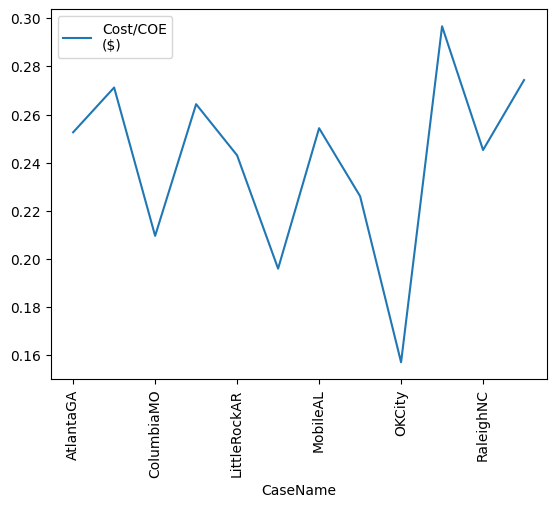

In [9]:
# DATA FOR LOC VAR
#for index = opt_out.ind 
#display(pd.MultiIndex.get_level_values(opt_out('CaseNum')))
CFA = opt_out.query("KCC=='cfa'")
#print(CFA.query("CaseNum=='Case1'"))
#CFA.plot(x='CaseName',y='Cost/COE\n($)')
Case1 = opt_out.loc[("Case1",slice(None))]
Case1CFA = Case1.query("KCC=='cfa'")
Case2 = opt_out.loc[("Case2",slice(None))]
Case2CFA = Case2.query("KCC=='cfa'")
Case25 = opt_out.loc[("Case25",slice(None))]
Case3 = opt_out.loc[("Case3",slice(None))]
Case3CFA = Case3.query("KCC=='cfa'")
Case35 = opt_out.loc[("Case35",slice(None))]
Case4 = opt_out.loc[("Case4",slice(None))]
Case4CFA = Case4.query("KCC=='cfa'")
#display(Case4)
# Testing
Case5 = opt_out.loc[("Case5",slice(None))]
Case6 = opt_out.loc[("Case6",slice(None))]
Case7 = opt_out.loc[("Case7",slice(None))]
Case8 = opt_out.loc[("Case8",slice(None))]
Case10 = opt_out.loc[("Case10",slice(None))]
Case11 = opt_out.loc[("Case11",slice(None))]
Case12 = opt_out.loc[("Case12",slice(None))]
Case13 = opt_out.loc[("Case13",slice(None))]
Case14 = opt_out.loc[("Case14",slice(None))]
Case15 = opt_out.loc[("Case15",slice(None))]
Case16 = opt_out.loc[("Case16",slice(None))]
#display(Case16)
Case1CFA.plot(y='Cost/COE\n($)', use_index=True)

plt.xticks(rotation=90);
plt.savefig(image_dir + '/loc_var.svg')

"KCC=='bwh'"

"KCC=='csa'"

"KCC=='csb'"

"KCC=='dfa'"

"KCC=='dfb'"

"KCC=='dfc'"

"KCC=='bsh'"

"KCC=='cfa'"

"KCC=='bsk'"

"KCC=='cfb'"

"KCC=='af'"

"KCC=='dsb'"

"KCC=='am'"

"KCC=='bwk'"

bwh
csa
csb
dfa
dfb
dfc
bsh
cfa
bsk
cfb
af
dsb
am
bwk
['PhoenixAZ', 'VegasNV', 'YumaAZ', 'MedfordOR', 'PrescottAZ', 'ReddingCA', 'Sacramento', 'BentonCountyOregon', 'Longview', 'MoscowID', 'BurlingtonVT', 'Chicago', 'ColumbusOH', 'DesMoinesIA', 'DetroitMI', 'LancasterPA', 'LincolnNE', 'SouthBendIN', 'WadenaMN', 'Ashland', 'BangorME', 'BismarckND', 'BrewsterMA', 'CoalvilleUT', 'IdahoFalls', 'LosAlamosNM', 'Syracuse', 'UPMich', 'Anchorage', 'CrestedButteCO', 'EielsonAFB', 'LaredoTX', 'TexasOil', 'AtlantaGA', 'BirminghamAL', 'ColumbiaMO', 'JacksonMS', 'LittleRockAR', 'MemphisTN', 'MobileAL', 'NOLA', 'OKCity', 'ORNL', 'RaleighNC', 'RichmondVA', 'BendOre', 'BlaineCountyMontana', 'BoiseID', 'CarsonCityNV', 'CheyenneWY', 'GreatFallsMT', 'Pueblo', 'RapidCitySD', 'Kauai', 'MarlintonWV', 'NeahBay', 'Hilo', 'Miami', 'Flagstaff', 'KootenaiCountyID', 'Everglades', 'Buttonwillow']
{'PhoenixAZ': 'black', 'VegasNV': 'red', 'YumaAZ': 'orange', 'MedfordOR': 'saddlebrown', 'PrescottAZ': 'gold', 'ReddingC

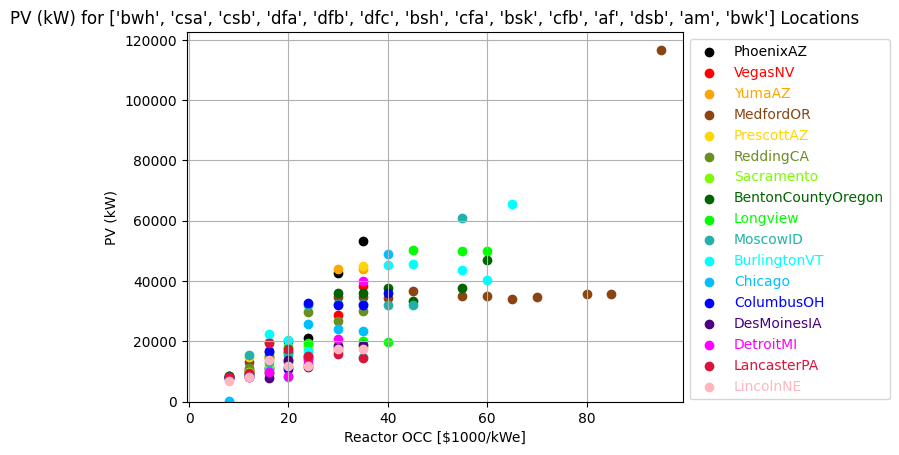

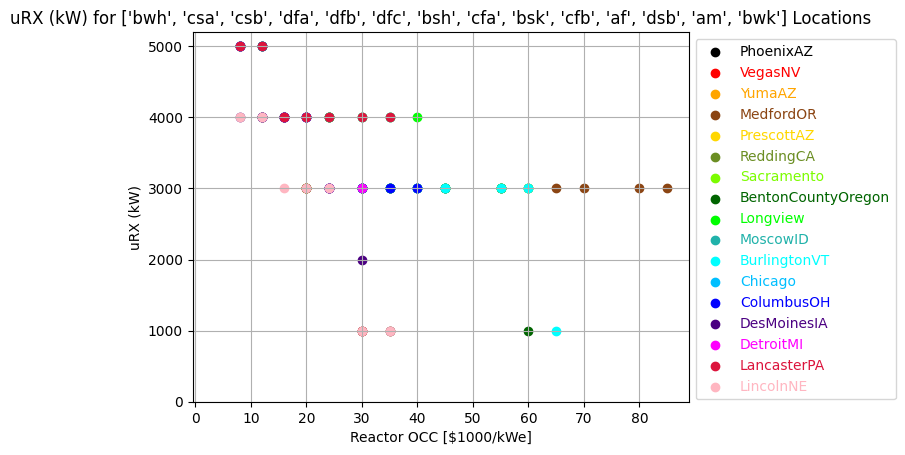

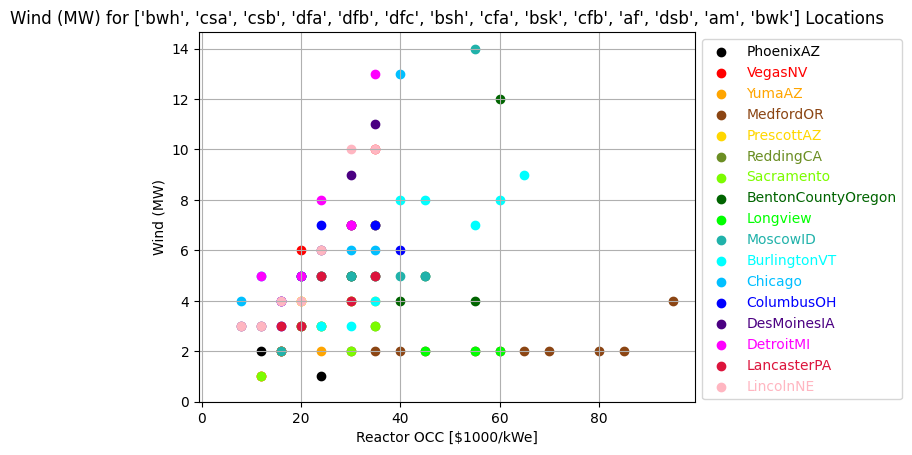

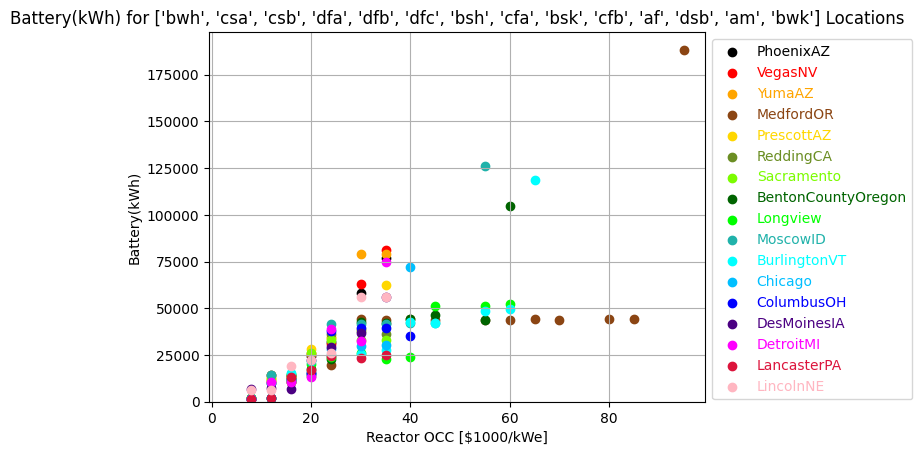

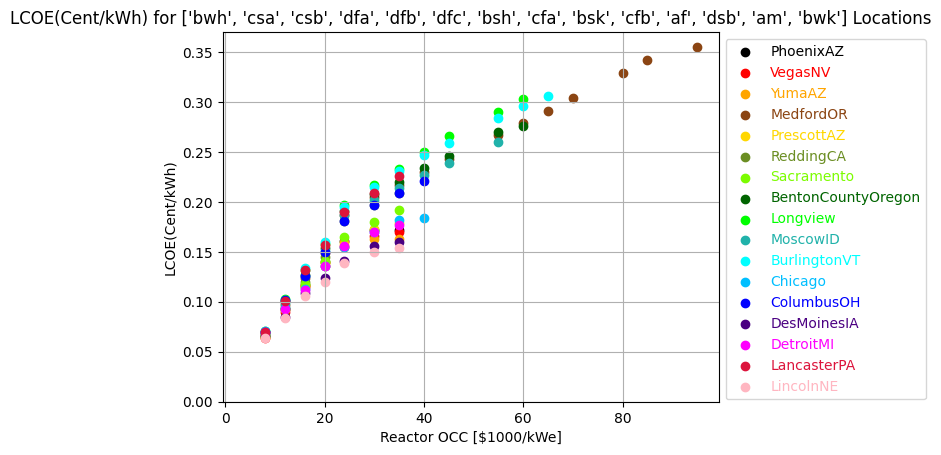

In [10]:
## STACKED BAR CHART TO DEMONSTRATE DATA BEFORE RAINBOW PLOT
koppens_modeled=['bwh', 'csa','csb','dfa','dfb','dfc', 'bsh',  'cfa', 'bsk', 'cfb',  'af', 'dsb', 'am',  'bwk']

#KCC = ['cfa',"cfb"]
KCC = koppens_modeled #[ 'dfa','dfb','dfc']
cases = [ 'Case2' , 'Case25' , 'Case3' , 'Case35' , 'Case4' , 'Case5' ,  'Case6',
         'Case7' , 'Case8' , 'Case10' , 'Case11' , 'Case12' , 'Case13',
        'Case14' , 'Case15',  'Case16'];

loc_var_dict = {}
for kcc in KCC:
    display("KCC==\'"+kcc + "\'") 
    loc_var_dict[kcc] =  opt_out.query("KCC==\'"+kcc + "\'");
    for c in cases:
        try: 
            c = loc_var_dict[kcc].loc[(str(c),slice(None))]
            #display(c)
        except:
            pass
#display(loc_var_dict)


# make as a loop that doesn't break?


colors = ['black', 'red', 'orange', 'saddlebrown', 'gold','olivedrab','lawngreen',
        'darkgreen','lime','lightseagreen','cyan','deepskyblue','blue',
        'indigo', 'fuchsia','crimson', 'lightpink']

costs = [ 8,12,16,20,24,30,35,40,45,55,60,65,70,80,85,95]


"""
FOR COLORS: APPLY DICTIONARY PAIRING AT START? MAP CITIES -> COLOR, CALL DICT FOR THAT?
"""
city_list = []
for kcc in KCC:
    print(kcc)
    for j in [i for i in loc_var_dict[kcc].loc['Case1'].index]:
        city_list.append(j)
print(city_list)
city_color = {k:v for (k,v) in zip(city_list, colors)}
print(city_color)



data_strs = ['Architecture/PV\n(kW)','Architecture/GenLarge\n(kW)', 'Architecture/G1500', 'Architecture/1kWh LI','Cost/COE\n($)']  # 'Architecture/PV\n(kW)','Architecture/GenLarge\n(kW)', 'Architecture/G1500', 'Architecture/1kWh LI','Cost/COE\n($)'
plot_str  = ['PV (kW)', 'uRX (kW)', 'Wind (MW)', 'Battery(kWh)', 'LCOE(Cent/kWh)']    # 'PV (kW)', 'uRX (kW)', 'Wind (kW)', 'Wind(kW)', 'LCOE($/MWh)' 
for str in range(len(data_strs)):
    legend_list = []
    plt.figure()
    string = data_strs[str]
    plot = plot_str[str]
    for k in KCC:
        cities = [i for i in loc_var_dict[k].loc['Case2'].index]
        demo = [i for i in costs]
        for i in range(len(demo)):
            cost_prof=cases[i]
            for j in cities:
                if j not in legend_list:
                    try:
                        plt.scatter(costs[i], loc_var_dict[k].loc[cost_prof].loc[j][string], color=city_color[j],label=j)
                        legend_list.append(j)
                    except: 
                        break 
                else:
                    try:
                        #print(type(costs[i]))
                        plt.scatter(costs[i], loc_var_dict[k].loc[cost_prof].loc[j][string], color=city_color[j])
                    except: 
                        break 
    
    plt.ylabel(f'{plot}')
    plt.xlabel('Reactor OCC [$1000/kWe]')
    plt.gca().set_ylim(bottom=0)
    plt.gca().set_xlim(left=-0.5)
    plt.legend(labelcolor='linecolor',bbox_to_anchor=(1, 1))
    plt.title(f'{plot} for {KCC} Locations', fontsize='large')
    plt.grid(True)
    plt_name = f'/loc_var_{kcc}_{str}.png'#f'/loc_var_{KCC}_{plot}.svg'
    plt.savefig(image_dir + plt_name)
    



In [11]:


cases = [Case2, Case25, Case3, Case35, Case4, Case5, Case6, Case7, Case8, Case10, Case11, Case12, Case13, Case14, Case15, Case16]
lat = coords_df['Latitude (decimal degrees)']
long = coords_df['Neg. Longitude']
places = coords_df['Name/Nearby Landmark']
kopppens = coords_df['KCC']
#for i in Case1.index.array:
#    #print(i)
#    #print(cases)
#    #try:
#    for j in cases:
#        print(i,j)
#        k=j.loc[i]['Cost/COE\n($)']*1000
#        #print(i,k)
#    #except:
#    #print("ran out of cases")
data = {'Location':places, 'KCC':kopppens ,'Latitude':lat, 'Longitude':long}
data_locvar = pd.DataFrame(data)

#display(data_locvar)
data_locvar.to_csv('LOCVARDATAFRAME.csv')

<Figure size 640x480 with 0 Axes>

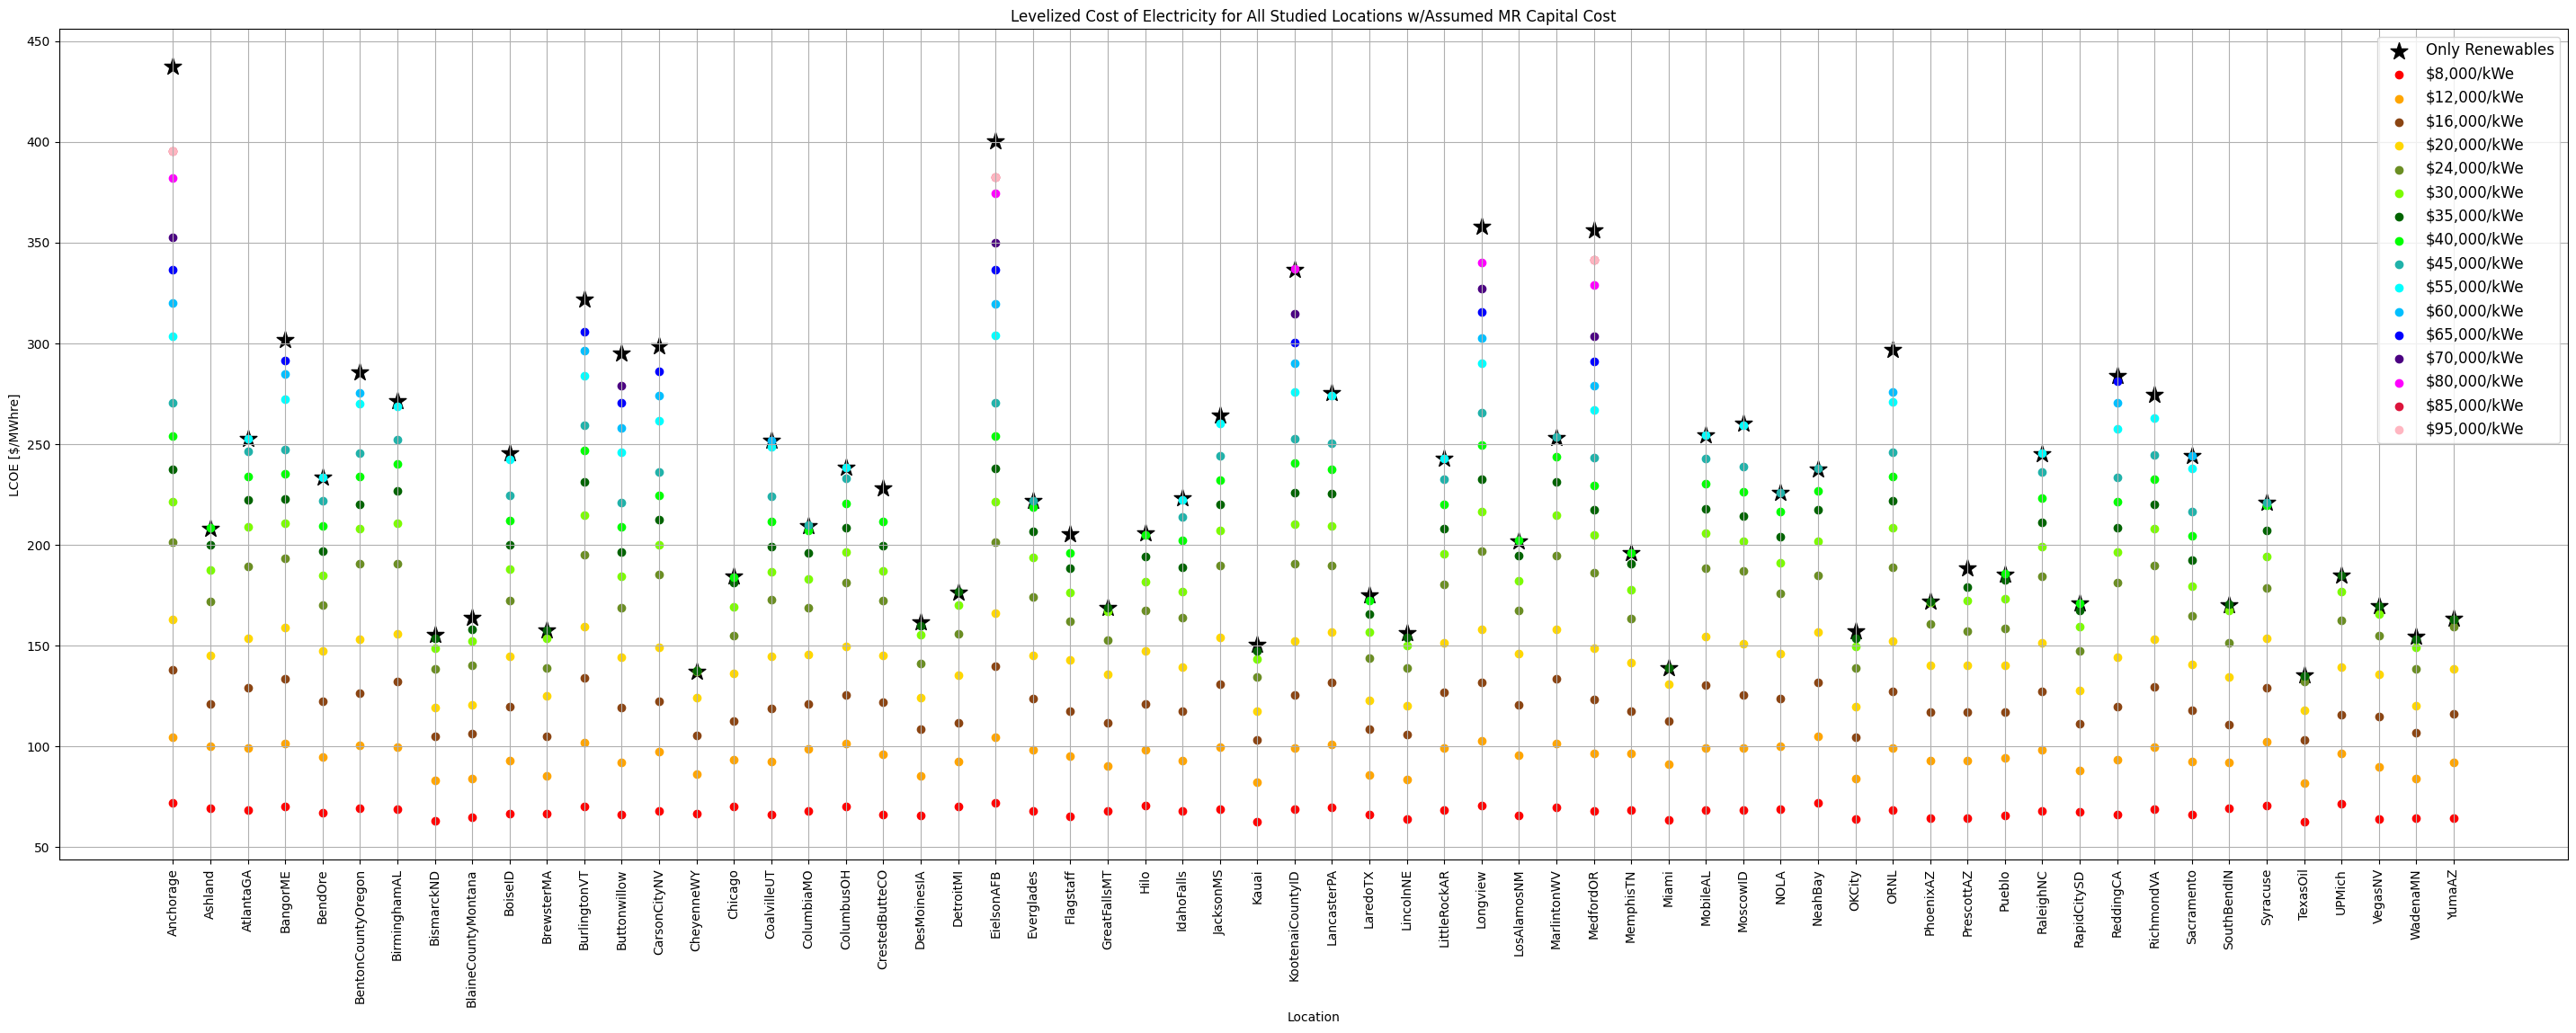

In [12]:
# KCC RAINBOW PLOT
with plt.rc_context():
    plt.rcParams['axes.prop_cycle'] = cycler(color=['black', 'red', 'orange', 'saddlebrown', 'gold','olivedrab','lawngreen',
                                                    'darkgreen','lime','lightseagreen','cyan','deepskyblue','blue',
                                                    'indigo', 'fuchsia','crimson', 'lightpink'])
    fig = plt.figure()
    fig, ax=plt.subplots(figsize=(36,12))
    ax.scatter( Case1.index.array, Case1['Cost/COE\n($)']*1000,marker='*',s=200)
    ax.scatter( Case2.index.array, Case2['Cost/COE\n($)']*1000)
    ax.scatter( Case25.index.array,Case25['Cost/COE\n($)']*1000)
    ax.scatter( Case3.index.array, Case3['Cost/COE\n($)']*1000)
    ax.scatter( Case35.index.array,Case35['Cost/COE\n($)']*1000)
    ax.scatter( Case4.index.array, Case4['Cost/COE\n($)']*1000)
    ax.scatter( Case5.index.array, Case5['Cost/COE\n($)']*1000)
    ax.scatter( Case6.index.array, Case6['Cost/COE\n($)']*1000)
    ax.scatter( Case7.index.array, Case7['Cost/COE\n($)']*1000)
    ax.scatter( Case8.index.array, Case8['Cost/COE\n($)']*1000)
    
    ax.scatter(Case10.index.array,Case10['Cost/COE\n($)']*1000)
    ax.scatter(Case11.index.array,Case11['Cost/COE\n($)']*1000)
    ax.scatter(Case12.index.array,Case12['Cost/COE\n($)']*1000)
    ax.scatter(Case13.index.array,Case13['Cost/COE\n($)']*1000)
    ax.scatter(Case14.index.array,Case14['Cost/COE\n($)']*1000)
    ax.scatter(Case15.index.array,Case15['Cost/COE\n($)']*1000)
    ax.scatter(Case15.index.array,Case15['Cost/COE\n($)']*1000)
    ax.legend(['Only Renewables', '$8,000/kWe','$12,000/kWe', 
               '$16,000/kWe', '$20,000/kWe','$24,000/kWe', '$30,000/kWe','$35,000/kWe','$40,000/kWe',
               '$45,000/kWe','$55,000/kWe','$60,000/kWe','$65,000/kWe','$70,000/kWe','$80,000/kWe',
               '$85,000/kWe','$95,000/kWe'], fontsize='large')
    plt.ylabel('LCOE [$/MWhre]')
    plt.xlabel('Location')
    plt.title('Levelized Cost of Electricity for All Studied Locations w/Assumed MR Capital Cost', fontsize='large')
    plt.xticks(rotation=90);
    ax.grid(True)

plt.savefig(image_dir + '/loc_var_rainbow.png')

In [13]:
KCC = ['cfa']
#print(mlr_opt_out)
mlr_dict = {}
cases_mlr = [ 'Case2' , 'Case3' ,'Case4'];
for kop in KCC:
    display("KCC==\'"+kop + "\'") 
    mlr_dict[kop] =  mlr_opt_out.query("KCC==\'"+kop + "\'");
    for c in cases_mlr:
        print(c)
        c = mlr_dict[kop].loc[(c,slice(None))]
        i = 0
        locs=[]
        indices=c.index
        for h in range(len(indices)):
            if indices[h][0] not in locs:
                locs.append(indices[h][0])
                i = i+1
            else:
                pass
        print(locs)
    #### ABOVE COLLECTS LOCATIONS AND CASES
    #### BELOW TURNS IT TO LOCATIONS -> CASES
    #### THIS DATA TRANSFORMATION ALLOWS INTEROGATION OF EACH INDIVIDUAL 
        for place in locs:
            index   = c.loc[place].index.array
            nuclear = c.loc[place]['Architecture/GenLarge\n(kW)'][0]
            solar   = c.loc[place]['Architecture/PV\n(kW)'][0]                
            wind    = c.loc[place]['Architecture/G1500'][0]                
            batt    = c.loc[place]['Architecture/1kWh LI'][0]  
            LCOE    = c.loc[place]['Cost/COE\n($)'][0]  
            print(f'LCOE: {LCOE}, Nuclear: {nuclear}')
    


"KCC=='cfa'"

Case2
['AtlantaGA', 'BirminghamAL', 'ColumbiaMO', 'JacksonMS', 'LittleRockAR', 'MemphisTN', 'MobileAL', 'NOLA', 'OKCity', 'ORNL', 'RaleighNC', 'RichmondVA']
LCOE: 0.06848271936178207, Nuclear: 5000
LCOE: 0.06873578578233719, Nuclear: 5000
LCOE: 0.06799489259719849, Nuclear: 5000
LCOE: 0.06867071986198425, Nuclear: 5000
LCOE: 0.06846340745687485, Nuclear: 5000
LCOE: 0.06856898963451385, Nuclear: 5000
LCOE: 0.06848882883787155, Nuclear: 5000
LCOE: 0.06898856163024902, Nuclear: 5000
LCOE: 0.06385663896799088, Nuclear: 4000
LCOE: 0.0684136375784874, Nuclear: 5000
LCOE: 0.0678156316280365, Nuclear: 5000
LCOE: 0.06863564997911453, Nuclear: 5000
Case3
['AtlantaGA', 'BirminghamAL', 'ColumbiaMO', 'JacksonMS', 'LittleRockAR', 'MemphisTN', 'MobileAL', 'NOLA', 'OKCity', 'ORNL', 'RaleighNC', 'RichmondVA']
LCOE: 0.12915197014808655, Nuclear: 4000
LCOE: 0.13219979405403137, Nuclear: 4000
LCOE: 0.12091311812400818, Nuclear: 4000
LCOE: 0.13093586266040802, Nuclear: 4000
LCOE: 0.1267920285463333, Nuclea

In [14]:
import math
# DATA FOR MLR
#for index = opt_out.ind 
#display(pd.MultiIndex.get_level_values(opt_out('CaseNum')))
cases = [ 'Case2' , 'Case3' , 'Case4'];
mlr_dict = {}

KCC = koppens_modeled

max_rel_diff = 0;
avg_diff=0
counter=0

max_rel_diff_solar = 0;
avg_diff_solar=0
counter_solar=0

max_rel_diff_wind = 0;
avg_diff_wind=0
counter_wind=0

max_rel_diff_batt = 0;
avg_diff_batt=0
counter_batt=0

max_rel_diff_nuclear = 0;
avg_diff_nuclear=0
counter_nuclear=0



for kcc in KCC:
    #display("KCC==\'"+kcc + "\'") 
    mlr_dict[kcc] =  mlr_opt_out.query("KCC==\'"+kcc + "\'");
    for c in cases:
        #print(c)
        #try: 
        c = mlr_dict[kcc].loc[(c,slice(None))]
        #print(c)
        i = 0
        locs=[]
        indices=c.index
        for h in range(len(indices)):
            if indices[h][0] not in locs:
                locs.append(indices[h][0])
                i = i+1
            else:
                pass

        for place in locs:
            rel_diff = (c.loc[place]['Cost/COE\n($)'][0] - c.loc[place]['Cost/COE\n($)'][-1])/c.loc[place]['Cost/COE\n($)'][-1]
            rel_diff_solar = abs((c.loc[place]['Architecture/PV\n(kW)'][0] - c.loc[place]['Architecture/PV\n(kW)'][-1])/c.loc[place]['Architecture/PV\n(kW)'][-1])
            rel_diff_wind  = abs((c.loc[place]['Architecture/G1500'][0] - c.loc[place]['Architecture/G1500'][-1])/c.loc[place]['Architecture/G1500'][-1])
            rel_diff_batt  = abs((c.loc[place]['Architecture/1kWh LI'][0] - c.loc[place]['Architecture/1kWh LI'][-1])/c.loc[place]['Architecture/1kWh LI'][-1])
            rel_diff_nuclear  = abs((c.loc[place]['Architecture/GenLarge\n(kW)'][0] - c.loc[place]['Architecture/GenLarge\n(kW)'][-1])/c.loc[place]['Architecture/GenLarge\n(kW)'][-1])
            # print(place)
            #print(rel_diff_batt*100, '%')
            if max_rel_diff < rel_diff:
                max_rel_diff = rel_diff
            if math.isnan(rel_diff):
                pass
            else:
                avg_diff = avg_diff + rel_diff
                counter=counter+1
                
                
            if max_rel_diff_solar < rel_diff_solar:
                max_rel_diff_solar = rel_diff_solar
            if math.isnan(rel_diff_solar):
                pass
            else:
                avg_diff_solar = avg_diff_solar + rel_diff_solar
                counter_solar=counter_solar+1
                
            if max_rel_diff_wind < rel_diff_wind:
                max_rel_diff_wind = rel_diff_wind
            if math.isnan(rel_diff_wind):
                pass
            else:
                avg_diff_wind = avg_diff_wind + rel_diff_wind
                counter_wind=counter_wind+1
    
            if max_rel_diff_batt < rel_diff_batt:
                max_rel_diff_batt = rel_diff_batt
            if math.isnan(rel_diff_batt):
                    pass
            else:
                avg_diff_batt = avg_diff_batt + rel_diff_batt
                counter_batt=counter_batt+1
            
            if max_rel_diff_nuclear < rel_diff_nuclear:
                max_rel_diff_nuclear = rel_diff_nuclear
            if math.isnan(rel_diff_nuclear):
                pass
            else:
                avg_diff_nuclear = avg_diff_nuclear + rel_diff_nuclear
                #print(avg_diff_nuclear)
                counter_nuclear=counter_nuclear+1
        #print('loop working properly')
        #except:
        #    pass
print('The average relative difference between MLR LCOEs is :', 100*(avg_diff/counter), '%.')
print('The maximum relative difference between MLR LCOEs extremes is : ',100*max_rel_diff, ' %.')   
print('The average relative difference between solar capacity in MLRs is :',            100*(avg_diff_solar/counter_solar), '%.')
print('The maximum relative difference between solar capacity in MLRs extremes is : ',  100*max_rel_diff_solar, ' %.')  
print('The average relative difference between wind capacity in MLRs is :',             100*(avg_diff_wind/counter_wind), '%.')
print('The maximum relative difference between wind capacity in MLRs extremes is : ',   100*max_rel_diff_wind, ' %.') 
print('The average relative difference between battery capacity in MLRs is :',          100*(avg_diff_batt/counter_batt), '%.')
print('The maximum relative difference between battery capacity in MLRs extremes is : ',100*max_rel_diff_batt, ' %.') 
print('The average relative difference between nuclear capacity in MLRs is :',          100*(avg_diff_nuclear/counter_nuclear), '%.')
print('The maximum relative difference between nuclear capacity in MLRs extremes is : ',100*max_rel_diff_nuclear, ' %.') 

testcase='Ashland'
quantity='Cost/COE\n($)'
Case2= mlr_opt_out.loc[("Case2",slice(None))]
Case3= mlr_opt_out.loc[("Case3",slice(None))]
Case4= mlr_opt_out.loc[("Case4",slice(None))]
Case2test = Case2.loc[(testcase,slice(None))]
Case3test = Case3.loc[(testcase,slice(None))]
Case4test = Case4.loc[(testcase,slice(None))]
fig = plt.figure()
fig, ax=plt.subplots(figsize=(8,4))
# 'Architecture/GenLarge\n(kW)'
ax.scatter( Case2test.index.array, Case2test[quantity],marker='*',s=200)
ax.scatter( Case3test.index.array, Case3test[quantity],marker='*',s=200)
ax.scatter( Case4test.index.array, Case4test[quantity],marker='*',s=200)
ax.legend(['$8,000/kWe','$16,000/kWe','$24,000/kWe'], fontsize='large')
plt.ylabel(quantity)
plt.xlabel('minimum load ratio [%]')
plt.title(f'Levelized Cost of Electricity for {testcase} w/ various Assumed MR Capital Cost', fontsize='large')
plt.xticks(rotation=90);
ax.grid(True)

plt.savefig(image_dir + '/mlr_pv.svg')
plt.close()

The average relative difference between MLR LCOEs is : 0.5612068211994683 %.
The maximum relative difference between MLR LCOEs extremes is :  5.2939024230425344  %.
The average relative difference between solar capacity in MLRs is : 4.6162170110789065 %.
The maximum relative difference between solar capacity in MLRs extremes is :  46.7472444378692  %.
The average relative difference between wind capacity in MLRs is : 3.527131782945736 %.
The maximum relative difference between wind capacity in MLRs extremes is :  100.0  %.
The average relative difference between battery capacity in MLRs is : 6.837658950426182 %.
The maximum relative difference between battery capacity in MLRs extremes is :  83.9520701829464  %.
The average relative difference between nuclear capacity in MLRs is : 0.45045045045045046 %.
The maximum relative difference between nuclear capacity in MLRs extremes is :  25.0  %.


<Figure size 640x480 with 0 Axes>

In [15]:
# DATA FOR util
low = util_opt_out.loc[("1.3MWe",slice(None))]
high = util_opt_out.loc[("2.6MWe",slice(None))]
display(low)
display(high)

Architecture/PV\n(kW)  Grid/Energy Purchased\n(kWh)  \
Price CaseName  KCC                                                        
12    Anchorage dfc           76800.800000                    5108567.00   
      Ashland   dfb           37469.778374                    3765344.50   
      AtlantaGA cfa           86083.370265                    6029559.50   
      BangorME  dfb           61569.338073                    5329595.50   
      BendOre   bsk           33742.500745                    4773864.50   
...                                    ...                           ...   
6     TexasOil  bsh           14611.443635                    4104589.75   
      UPMich    dfb           43145.927351                    3476247.00   
      VegasNV   bwh           28984.103688                    5524351.50   
      WadenaMN  dfa           17883.455890                    3594086.50   
      YumaAZ    bwh           37010.294715                    5900801.50   

                    Architecture/G1500 Architecture/1kWh LI  Cost/COE\n($)  
Price CaseName  KCC                                                         
12    Anchorage dfc                 19               133933       0.323477  
      Ashland   dfb                 14                59708       0.174181  
      AtlantaGA cfa                  2                70298       0.207359  
      BangorME  dfb                  8                98826       0.227301  
      BendOre   bsk                 12                74259       0.180699  
...                                ...                  ...            ...  
6     TexasOil  bsh                  7                49555       0.103177  
      UPMich    dfb                 11                49106       0.151799  
      VegasNV   bwh                  5                61121       0.127779  
      WadenaMN  dfa                  9                51198       0.115601  
      YumaAZ    bwh                  3                60090       0.129655  

[310 rows x 5 columns]

Architecture/PV\n(kW)  Grid/Energy Purchased\n(kWh)  \
Price CaseName  KCC                                                        
12    Anchorage dfc           51260.488144                    12587906.0   
      Ashland   dfb           31857.000867                     7956376.0   
      AtlantaGA cfa           53323.749534                    12503425.0   
      BangorME  dfb           51088.173894                    11771956.0   
      BendOre   bsk           26260.764409                    11341762.0   
...                                    ...                           ...   
6     TexasOil  bsh            9868.654810                     7956019.5   
      UPMich    dfb           20787.229111                     6746716.5   
      VegasNV   bwh           20565.506421                    12421933.0   
      WadenaMN  dfa           13802.910637                     7630152.5   
      YumaAZ    bwh           23972.819896                    12382070.0   

                    Architecture/G1500 Architecture/1kWh LI  Cost/COE\n($)  
Price CaseName  KCC                                                         
12    Anchorage dfc                  5                66206       0.194136  
      Ashland   dfb                  9                33291       0.135178  
      AtlantaGA cfa                NaN                47365       0.157814  
      BangorME  dfb                  3                48532       0.165122  
      BendOre   bsk                  4                38063       0.126003  
...                                ...                  ...            ...  
6     TexasOil  bsh                  6                24838       0.074369  
      UPMich    dfb                 10                36086       0.112565  
      VegasNV   bwh                  1                36208       0.088137  
      WadenaMN  dfa                  6                25410       0.079242  
      YumaAZ    bwh                1.0                37466       0.093565  

[310 rows x 5 columns]

appended
appended
appended
appended
appended
dfc
low_6
high_6
Index(['Anchorage', 'CrestedButteCO', 'EielsonAFB'], dtype='object', name='CaseName')
low_12
high_12
Index(['Anchorage', 'CrestedButteCO', 'EielsonAFB'], dtype='object', name='CaseName')
low_18
high_18
Index(['Anchorage', 'CrestedButteCO', 'EielsonAFB'], dtype='object', name='CaseName')
low_24
high_24
Index(['Anchorage', 'CrestedButteCO', 'EielsonAFB'], dtype='object', name='CaseName')
low_30
high_30
Index(['Anchorage', 'CrestedButteCO', 'EielsonAFB'], dtype='object', name='CaseName')
bsk
low_6
high_6
Index(['BendOre', 'BlaineCountyMontana', 'BoiseID', 'CarsonCityNV',
       'CheyenneWY', 'GreatFallsMT', 'Pueblo', 'RapidCitySD'],
      dtype='object', name='CaseName')
low_12
high_12
Index(['BendOre', 'BlaineCountyMontana', 'BoiseID', 'CarsonCityNV',
       'CheyenneWY', 'GreatFallsMT', 'Pueblo', 'RapidCitySD'],
      dtype='object', name='CaseName')
low_18
high_18
Index(['BendOre', 'BlaineCountyMontana', 'BoiseID', 'CarsonCi

<Figure size 640x480 with 0 Axes>

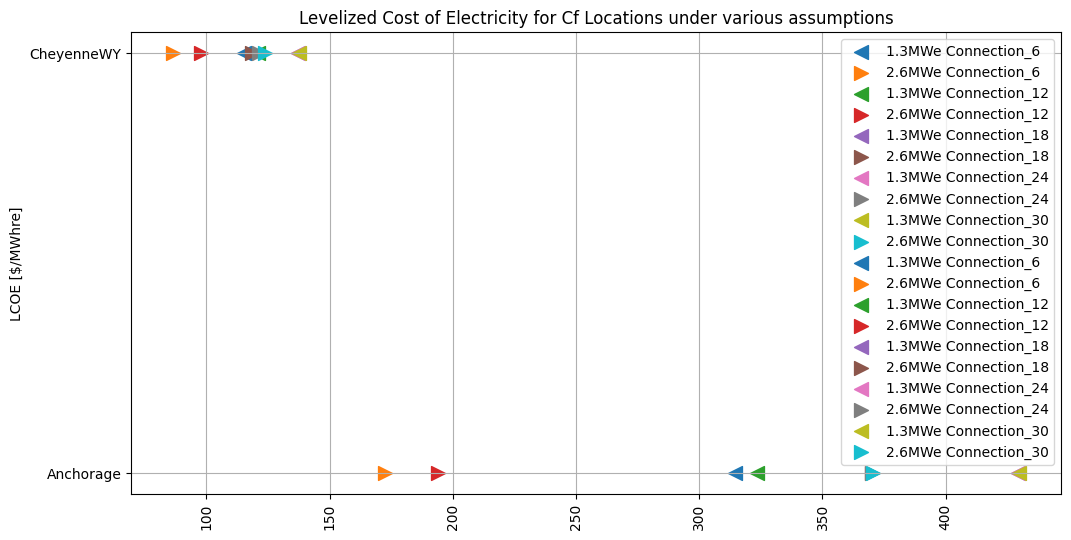

In [16]:
## Comparing high utility throughput to low utility throughput 
utility_price = [6, 12, 18, 24, 30]
utility_dict = {}
str_names = []
for i in utility_price:
    low_strname = f"low_{i}" #collects 1.3MWe utility case
    if low_strname not in str_names:
        str_names.append(low_strname)
    high_strname = f"high_{i}" #collect 2.6 MWe utility case
    if high_strname not in str_names:
        print('appended')
        str_names.append(high_strname)
    utility_dict[low_strname] = low.query(f"Price=='{i}'")
    utility_dict[high_strname] = high.query(f"Price=='{i}'")


fig = plt.figure()
fig, ax =plt.subplots(figsize=(12,6))
koppen = ['dfc','bsk']
legend_list = []
for j in koppen:
    print(j)
    if j == 'dfc':
        int=0
    else: 
        int=4
    for i in str_names:
        print(i)
        if i not in legend_list:
            if 'high' in i:
                    legend_list.append(i.replace('high_','2.6MWe Connection_'))
                    print(utility_dict[f'{i}'].query(f"KCC== '{j}'").droplevel(['Price','KCC']).index)
                    plt.scatter( utility_dict[f'{i}'].query(f"KCC== '{j}'")['Cost/COE\n($)'][int]*1000,utility_dict[f'{i}'].query(f"KCC== '{j}'").droplevel(['Price','KCC']).index[int]   ,marker='>',s=100)
            if 'low' in i:
                    legend_list.append(i.replace('low_','1.3MWe Connection_'))
                    plt.scatter( utility_dict[f'{i}'].query(f"KCC== '{j}'")['Cost/COE\n($)'][int]*1000,utility_dict[f'{i}'].query(f"KCC== '{j}'").droplevel(['Price','KCC']).index[int]   ,marker='<',s=100)



plt.xticks(rotation=90);
plt.legend(legend_list)
plt.ylabel('LCOE [$/MWhre]')
plt.title('Levelized Cost of Electricity for Cf Locations under various assumptions', fontsize='large')
plt.grid(True);
plt.savefig(image_dir + '/util_contin.svg')

low_6
high_6
low_12
high_12
low_18
high_18
low_24
high_24
low_30
high_30
['6', '12', '18', '24', '30']
[0.17233681678771973, 0.1941358894109726, 0.3700718879699707, 0.3702836334705353, 0.3704598546028137]
[0.3147043287754059, 0.32347726821899414, 0.429386168718338, 0.4294368624687195, 0.4297022223472595]
low_6
high_6
low_12
high_12
low_18
high_18
low_24
high_24
low_30
high_30
['6', '12', '18', '24', '30']
[0.13200868666172028, 0.14842070639133453, 0.20557071268558502, 0.20586222410202026, 0.20622552931308746]
[0.18675698339939117, 0.19381867349147797, 0.231492280960083, 0.23157846927642822, 0.2316923588514328]
low_6
high_6
low_12
high_12
low_18
high_18
low_24
high_24
low_30
high_30
['6', '12', '18', '24', '30']
[0.08661902695894241, 0.09789922088384628, 0.11830876767635345, 0.12122360616922379, 0.12374693900346756]
[0.11522318422794342, 0.12083317339420319, 0.13728348910808563, 0.13733883202075958, 0.13739416003227234]


<Figure size 640x480 with 0 Axes>

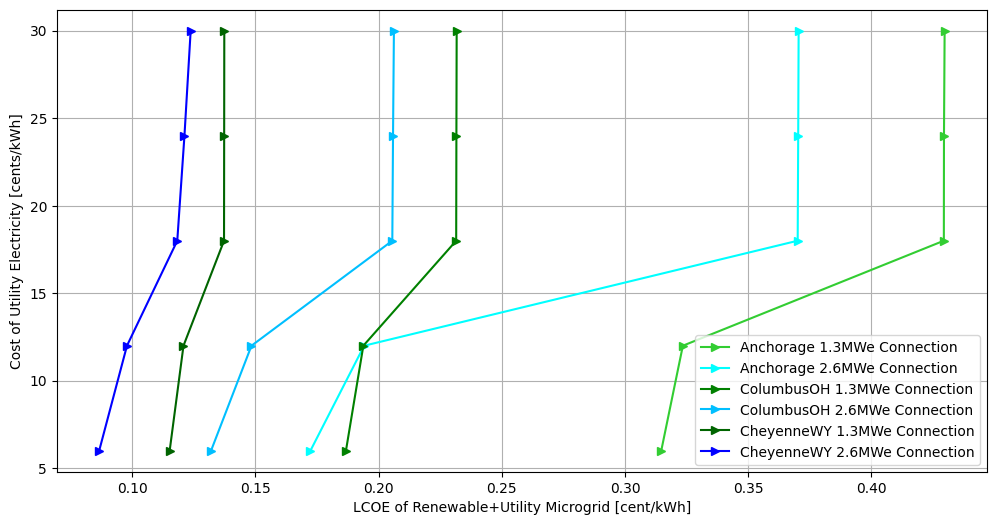

In [17]:
### PLOTTING LINE OF UTILITY COSTS FOR EIELSON, Cheyenne
costs = [ '8','12','16','20','24','30','35','40','45','55','60','65','70','80','85','95']
fig = plt.figure()
fig, ax =plt.subplots(figsize=(12,6))
legend_list = ['Anchorage','ColumbusOH','CheyenneWY']
#legend_list = ['Anchorage','EielsonAFB']
koppen = ['dfc']
counter=0
for k in legend_list:
    price_high = []
    price_low = []
    LCOE_high  = []
    LCOE_low  = []
    for j in str_names:
        casename = k
        print(j)
        #display(utility_dict[j].query(f"CaseName== '{k}'").droplevel(['CaseName','KCC']).index)
        if 'high' in j:
            price_high.append(utility_dict[j].query(f"CaseName== '{k}'").droplevel(['CaseName','KCC']).index[0])
            LCOE_high.append(utility_dict[j].query(f"CaseName== '{k}'").droplevel(['CaseName','KCC'])['Cost/COE\n($)'][0])
        else: 
            price_low.append(utility_dict[j].query(f"CaseName== '{k}'").droplevel(['CaseName','KCC']).index[0])
            LCOE_low.append(utility_dict[j].query(f"CaseName== '{k}'").droplevel(['CaseName','KCC'])['Cost/COE\n($)'][0])
    print(price_high)
    print(LCOE_high)
    print(LCOE_low)
    if counter ==0:
        high_color='cyan'
        low_color ='limegreen'
    elif counter ==1:
        high_color='deepskyblue'
        low_color ='green'
    else:
        high_color = 'blue'
        low_color  = 'darkgreen'
    counter=counter+1
    plt.plot( LCOE_low,[6,12,18,24,30],label=f'{k} 1.3MWe Connection', marker='>',color=low_color)
    plt.plot(LCOE_high,[6,12,18,24,30],label=f'{k} 2.6MWe Connection', marker='>',color=high_color)
    plt.ylabel('Cost of Utility Electricity [cents/kWh]')
    plt.xlabel('LCOE of Renewable+Utility Microgrid [cent/kWh]')
    #plt.ylim([0.05, 0.50])
    plt.grid(True)
    plt.legend()
    #ax2 = plt.twiny()
    #
    #data_strs = ['Cost/COE\n($)']  # 'Architecture/PV\n(kW)','Architecture/GenLarge\n(kW)', 'Architecture/G1500', 'Architecture/1kWh LI','Cost/COE\n($)'
    #plot_str  = ['LCOE(Cent/kWh)']    # 'PV (kW)', 'uRX (kW)', 'Wind (kW)', 'Wind(kW)', 'LCOE($/MWh)' 
    #for str in range(len(data_strs)):
    #    legend_list = []
    #    string = data_strs[str]
    #    plot = plot_str[str]
    #    for k in koppen:
    #        counter=0
    #        cities = legend_list
    #        demo = [i for i in costs]
    #        print(demo)
    #        for i in range(len(costs)):
#
    #            cost_prof=cases[i]
    #            for j in cities:
    #                if counter ==0:
    #                    try:
    #                        ax2.scatter(costs[i], loc_var_dict[k].loc[cost_prof].loc[j][string],label=f'{j} Reactor Cases',color='red')
    #                        counter=counter+1;
    #                    except:
    #                        print("ran out of cases")
    #                else:    
    #                    try:
    #                        ax2.scatter(costs[i], loc_var_dict[k].loc[cost_prof].loc[j][string],color='red')
    #                        counter=counter+1;
    #                    except:
    #                        print("ran out of cases")
#
    #            ax2.set_xlabel('Microreactor OCC [$1000/kWe]')
    #            ax2.legend(loc='upper left')
    #            plt.savefig(image_dir + f'/util_uRX_LCOE_{j}.png')  


  


{'bwh': {'PhoenixAZ': [8400.087499999998, 10683.391731439355, 11261.379617329401, 20003.424733772725, 21183.03602222512, 42565.862223304925, 53373.960594344455], 'VegasNV': [8000.083333333334, 9839.135585880831, 9611.743061859022, 11645.311278673717, 12652.728562740122, 28709.79821561277, 38302.86931984132], 'YumaAZ': [8400.087499999998, 10315.821714642287, 10727.239292415772, 16173.290729728447, 18946.59316675606, 43852.5062308689, 43852.5062308689]}, 'csa': {'MedfordOR': [8183.429249796184, 13096.280277645648, 15000.156249999998, 13825.377167891082, 15249.98760816626, 34698.950091304236, 34765.19939693372, 34418.096393282925, 36593.54229677982, 35084.121947426174, 35084.121947426174, 34226.29273827486, 34682.466601503394, 35556.38192244299, 35556.38192244299, 116738.95007120816], 'PrescottAZ': [8164.946707077324, 14800.305823564016, 14339.7530244309, 17893.38472391963, 15912.32427076639, 16653.136836823596, 44842.11502946755], 'ReddingCA': [8429.17293095298, 11260.760226293556, 14633


{'bwh': {'PhoenixAZ': [nan, 2.0, 2.0, 3.0, 1.0, 5.0, 7.0], 'VegasNV': [nan, 1.0, 2.0, 6.0, 5.0, 7.0, 10.0], 'YumaAZ': [nan, 1.0, 2.0, 4.0, 2.0, 7.0, 7.0]}, 'csa': {'MedfordOR': [nan, nan, nan, nan, nan, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 4.0], 'PrescottAZ': [nan, nan, nan, 4.0, 5.0, 4.0, 4.0], 'ReddingCA': [nan, nan, nan, nan, 3.0, 4.0, 3.0, 1.0, 4.0, 3.0, 4.0, 6.0], 'Sacramento': [nan, 1.0, nan, 3.0, 3.0, 2.0, 3.0, 3.0, 2.0, 9.0, 7.0]}, 'csb': {'BentonCountyOregon': [nan, nan, nan, nan, nan, 5.0, 5.0, 4.0, 5.0, 4.0, 12.0], 'Longview': [nan, nan, nan, nan, nan, nan, nan, nan, 2.0, 2.0, 2.0, 2.0, 2.0, 17.0], 'MoscowID': [nan, nan, 2.0, nan, 5.0, 5.0, 5.0, 5.0, 5.0, 14.0]}, 'dfa': {'BurlingtonVT': [nan, nan, nan, nan, 3.0, 3.0, 4.0, 8.0, 8.0, 7.0, 8.0, 9.0], 'Chicago': [4.0, 5.0, 4.0, 5.0, 5.0, 6.0, 6.0, 13.0], 'ColumbusOH': [nan, nan, 3.0, 5.0, 7.0, 7.0, 7.0, 6.0, 6.0, 15.0], 'DesMoinesIA': [3.0, 3.0, 4.0, 5.0, 6.0, 9.0, 11.0], 'DetroitMI': [nan, 5.0, 4.0, 5.0, 8.0, 7.0,

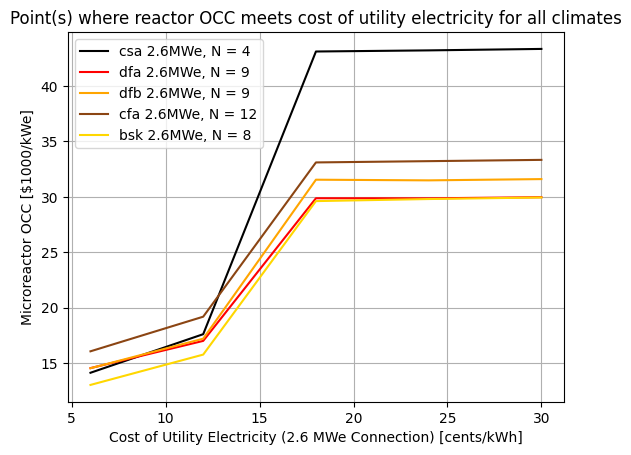

In [159]:
import statistics as stats
### PLOTTING LINE OF UTILITY COSTS VS uRX costs
costs = [ 8,12,16,20,24,30,35,40,45,55,60,65,70,80,85,95]
cases = [ 'Case2' , 'Case25' , 'Case3' , 'Case35' , 'Case4' , 'Case5' ,  'Case6',
         'Case7' , 'Case8' , 'Case10' , 'Case11' , 'Case12' , 'Case13',
        'Case14' , 'Case15',  'Case16'];
# koppen = ['dfa','dfb','dfc']
koppen=['bwh', 'csa','csb','dfa','dfb','dfc', 'bsh',  'cfa', 'bsk', 'cfb',  'af', 'dsb', 'am',  'bwk']
plotting_cities = {}
for kcc in koppen:
        plotting_cities[kcc] = [i for i in loc_var_dict[kcc].loc['Case1'].index]
#display(plotting_cities)
#plotting_cities = ['Anchorage', 'EielsonAFB'] 

price_high_dict_koppen= {}
price_low_dict_koppen = {}
LCOE_high_dict_koppen = {}
LCOE_low_dict_koppen  = {}
for kcc in koppen:
    price_high_dict= {}
    price_low_dict = {}
    LCOE_high_dict = {}
    LCOE_low_dict  = {}
    for k in plotting_cities[kcc]:
        price_high =[]
        price_low  =[]
        LCOE_low   =[]
        LCOE_high  =[]
        for j in str_names:
            casename = k
            if 'high' in j:
                price_high.append(utility_dict[j].query(f"CaseName== '{k}'").droplevel(['CaseName','KCC']).index[0])
                LCOE_high.append(utility_dict[j].query(f"CaseName== '{k}'").droplevel(['CaseName','KCC'])['Cost/COE\n($)'][0])
            else: 
                price_low.append(utility_dict[j].query(f"CaseName== '{k}'").droplevel(['CaseName','KCC']).index[0])
                LCOE_low.append(utility_dict[j].query(f"CaseName== '{k}'").droplevel(['CaseName','KCC'])['Cost/COE\n($)'][0])
        price_high_dict[k]= price_high
        price_low_dict[k] = price_low
        LCOE_high_dict[k] = LCOE_high
        LCOE_low_dict[k]  = LCOE_low
    price_high_dict_koppen[kcc] = price_high_dict
    price_low_dict_koppen[kcc]  = price_low_dict
    LCOE_high_dict_koppen[kcc]  = LCOE_high_dict
    LCOE_low_dict_koppen[kcc]   = LCOE_low_dict
#print(LCOE_high_dict_koppen)   
    
data_strs = ['Architecture/G1500','Architecture/PV\n(kW)','Cost/COE\n($)']  # 'Architecture/PV\n(kW)','Architecture/GenLarge\n(kW)', 'Architecture/G1500', 'Architecture/1kWh LI','Cost/COE\n($)'
plot_str  = ['LCOE(Cent/kWh)']    # 'PV (kW)', 'uRX (kW)', 'Wind (kW)', 'Wind(kW)', 'LCOE($/MWh)' 
uRX_cost_dict_koppen={}
uRX_LCOE_dict_koppen={}

PV_dict_koppen={}

Wind_dict_koppen={}
for str in range(len(data_strs)):
    string = data_strs[str]
    #plot = plot_str[str]
    for kcc in koppen:
        uRX_cost_dict={}
        uRX_LCOE_dict={}
        for j in plotting_cities[kcc]:
            uRX_cost_list=[]
            uRX_LCOE_list=[]
            counter=0
            try:
                for i in range(len(costs)):
                    cost_prof=cases[i]
                    if counter ==0:
                        try:
                            uRX_cost=costs[i]
                            uRX_LCOE=loc_var_dict[kcc].loc[cost_prof].loc[j][string]
                            uRX_cost_list.append(uRX_cost)
                            uRX_LCOE_list.append(uRX_LCOE)
                            counter=counter+1;
                        except:
                            pass #print("ran out of cases")
                    else:    
                        try:
                            uRX_cost=costs[i]
                            uRX_LCOE=loc_var_dict[kcc].loc[cost_prof].loc[j][string]
                            uRX_cost_list.append(uRX_cost)
                            uRX_LCOE_list.append(uRX_LCOE)
                            counter=counter+1;
                        except:
                            pass #print("ran out of cases")
            except:
                print('city not in current KCC')
            uRX_cost_dict[j] = uRX_cost_list
            uRX_LCOE_dict[j] = uRX_LCOE_list
        if string == 'Cost/COE\n($)':
            uRX_cost_dict_koppen[kcc] = uRX_cost_dict
            uRX_LCOE_dict_koppen[kcc] = uRX_LCOE_dict
        elif string=='Architecture/PV\n(kW)':
            PV_dict_koppen[kcc] = uRX_LCOE_dict
        elif string=='Architecture/G1500':
            Wind_dict_koppen[kcc] = uRX_LCOE_dict

        
graph_pnts_high_kcc_dict={}
graph_pnts_low_kcc_dict ={}
graph_pnts_high_max_kcc_err_avg_dict={}
graph_pnts_low_max_kcc_err_avg_dict ={}
graph_pnts_high_min_kcc_err_avg_dict={}
graph_pnts_low_min_kcc_err_avg_dict ={}
for kcc in koppen:
    graph_pnts_high_dict={}
    graph_pnts_low_dict ={}
    #plt.figure()
    graph_min_low=[1E6,1E6,1E6,1E6,1E6]
    graph_max_low=[0,0,0,0,0]
    
    graph_min_high=[1E6,1E6,1E6,1E6,1E6]
    graph_max_high=[0,0,0,0,0]
    for city in plotting_cities[kcc]:
        #try:
        graph_pts_high=[]
        graph_pts_low=[]
        for pt in range(len(LCOE_high_dict_koppen[kcc][city])):
            #try:
            util_high=LCOE_high_dict_koppen[kcc][city][pt]
            util_low =LCOE_low_dict_koppen[kcc][city][pt]
            #print(kcc, city, pt, util_high, uRX_LCOE_dict_koppen[kcc][city],uRX_cost_dict_koppen[kcc][city])
            uRX_cost_high=np.interp(util_high, uRX_LCOE_dict_koppen[kcc][city],uRX_cost_dict_koppen[kcc][city])
            uRX_cost_low=np.interp(util_low, uRX_LCOE_dict_koppen[kcc][city],uRX_cost_dict_koppen[kcc][city])
            graph_pts_high.append(uRX_cost_high)
            graph_pts_low.append(uRX_cost_low)
            #print(graph_pts_high)
            if uRX_cost_high < graph_min_high[pt]:
                    graph_min_high[pt] = uRX_cost_high
                
                
            elif uRX_cost_low < graph_min_low[pt]:
                    graph_min_low[pt] = uRX_cost_low
                
                
            elif uRX_cost_high > graph_max_high[pt]:
                    graph_max_high[pt] = uRX_cost_high
                
                
            elif uRX_cost_low > graph_max_low[pt]:
                    graph_max_low[pt] = uRX_cost_low
            #except:
            #    pass #print('kcc-city pair did not work')
        graph_pnts_high_dict[city] = graph_pts_high
        graph_pnts_low_dict[city]  = graph_pts_low
        plt.plot([6,12,18,24,30],graph_pts_high,label=f'{city} 2.6MWe')
        plt.plot([6,12,18,24,30],graph_pts_low,linestyle='dashed',label=f'{city} 1.3MWe')
        #except:
        #    pass #print('city wasnt in this set')
    graph_pnts_high_max_kcc_err_avg_dict[kcc]=graph_max_high
    graph_pnts_low_max_kcc_err_avg_dict [kcc]=graph_max_low
    graph_pnts_high_min_kcc_err_avg_dict[kcc]=graph_min_high
    graph_pnts_low_min_kcc_err_avg_dict [kcc]=graph_min_high
    plt.yticks(np.arange(0,100,10))
    plt.xlabel('Cost of Utility Electricity [cents/kWh]')
    plt.ylabel('Microreactor OCC [$1000/kWe]')
    plt.title(f'Point(s) where reactor OCC meets cost of utility electricity for dfc')
    plt.grid(True)
    plt.legend()
    graph_pnts_high_kcc_dict[kcc] = graph_pnts_high_dict
    graph_pnts_low_kcc_dict[kcc]  =  graph_pnts_low_dict
    plt.savefig(image_dir + f'/koppen_cities/koppen_cities_{kcc}.png')
    plt.clf()
# Plotting for individual cities, needs adjustment for new dictionary structure
#print(graph_pnts_high_kcc_dict, graph_pnts_low_max_kcc_err_avg_dict,graph_pnts_low_min_kcc_err_avg_dict)

    
    
graph_pnts_high_kcc_avg_dict={}
graph_pnts_low_kcc_avg_dict ={}    
for kcc in koppen:
    avg_pnts_high = [0, 0, 0, 0, 0]
    avg_pnts_low  = [0, 0, 0, 0, 0]
    for city in graph_pnts_high_kcc_dict[kcc]:
        counter=0
        for i in graph_pnts_high_kcc_dict[kcc][city]:
            avg_pnts_high[counter] = avg_pnts_high[counter] + i
            counter = counter +1
    #print(avg_pnts_high)   
            
    for city in graph_pnts_low_kcc_dict[kcc]:
        counter=0
        std_list_low.append(graph_pnts_low_kcc_dict[kcc])
        for i in graph_pnts_low_kcc_dict[kcc][city]:
            avg_pnts_low[counter]  = avg_pnts_low[counter] + i
            counter = counter +1
    #print(len(graph_pnts_high_kcc_dict[kcc].keys()))
    averaged_pnts_high = [x/len(graph_pnts_high_kcc_dict[kcc].keys()) for x in avg_pnts_high]
    averaged_pnts_low  = [x/len(graph_pnts_low_kcc_dict[kcc].keys())  for x in avg_pnts_low]
    graph_pnts_high_kcc_avg_dict[kcc]=averaged_pnts_high
    graph_pnts_low_kcc_avg_dict[kcc] =averaged_pnts_low
    #print(graph_pnts_high_kcc_avg_dict[kcc])
    graph_pnts_high_max_kcc_err_avg_dict[kcc] = [abs(averaged_pnts_high[i]- graph_pnts_high_max_kcc_err_avg_dict[kcc][i])  for i in range(len(averaged_pnts_high))]
    graph_pnts_low_max_kcc_err_avg_dict[kcc]  = [abs(averaged_pnts_low[i] - graph_pnts_low_max_kcc_err_avg_dict[kcc][i] )  for i in range(len(averaged_pnts_low))]
    graph_pnts_high_min_kcc_err_avg_dict[kcc] = [abs(averaged_pnts_high[i]- graph_pnts_high_min_kcc_err_avg_dict[kcc][i])  for i in range(len(averaged_pnts_high))]
    graph_pnts_low_min_kcc_err_avg_dict[kcc]  = [abs(averaged_pnts_low[i] - graph_pnts_low_min_kcc_err_avg_dict[kcc][i] )  for i in range(len(averaged_pnts_low))]
    #print(graph_pnts_low_min_kcc_err_avg_dict[kcc] )      

high_err_array ={}
low_err_array  ={}
for kcc in koppen:
    list_of_highs = []
    list_of_lows  = []
    for city in plotting_cities[kcc]:
        list_of_highs.append(graph_pnts_high_kcc_dict[kcc][city])
        list_of_lows.append(graph_pnts_low_kcc_dict[kcc][city])
    high_err_array[kcc] = np.std(np.array(list_of_highs),axis=0)
    low_err_array[kcc]  = np.std(np.array(list_of_lows),axis=0)

#display(graph_pnts_high_min_kcc_avg_err_dict)
color_pallete = ['black', 'red', 'orange', 'saddlebrown', 'gold','olivedrab','lawngreen',
                                                    'darkgreen','lime','lightseagreen','cyan','deepskyblue','blue',
                                                    'indigo', 'fuchsia','crimson', 'lightpink']          
counter = 0       
#plot = 'd'
descriptor = 'all'
#koppen=['dfc','dfb','dfa']
for kcc in koppen:
    if len(graph_pnts_low_kcc_dict[kcc].keys()) > 3:
        #if plot in kcc[0]:
        #print((graph_pnts_low_kcc_avg_dict[kcc]))
        #plt.figure()
        plt.plot([6,12,18,24,30],graph_pnts_low_kcc_avg_dict[kcc],color=color_pallete[counter], linestyle='dashed',label=f'{kcc} 1.3MWe, N = {len(graph_pnts_low_kcc_dict[kcc].keys())}')
        #plt.yticks(np.arange(0,60,10))
        #plt.errorbar([6,12,18,24,30],graph_pnts_low_kcc_avg_dict[kcc],yerr=[low_err_array[kcc]],capsize=5,color=color_pallete[counter])
        plt.xlabel('Cost of Utility Electricity (1.3MWe Connection) [cents/kWh]')
        plt.ylabel('Microreactor OCC [$1000/kWe]')
        plt.title(f'Point(s) where reactor OCC meets cost of utility electricity for {descriptor} climates')
        plt.grid(True)
        plt.legend()
        counter= counter+1
    else:
        pass
plt.savefig(image_dir + f'/allkcc_avg_1.3MWe_util_{descriptor}.png')
plt.clf()

counter = 0
for kcc in koppen:
    if len(graph_pnts_high_kcc_dict[kcc].keys()) > 3:
        plt.plot([6,12,18,24,30],graph_pnts_high_kcc_avg_dict[kcc],color=color_pallete[counter],label=f'{kcc} 2.6MWe, N = {len(graph_pnts_high_kcc_dict[kcc].keys())}')
        #plt.errorbar([6,12,18,24,30],graph_pnts_high_kcc_avg_dict[kcc],yerr=[high_err_array[kcc]],capsize=5,color=color_pallete[counter])
        plt.xlabel('Cost of Utility Electricity (2.6 MWe Connection) [cents/kWh]')
        plt.ylabel('Microreactor OCC [$1000/kWe]')
        plt.title(f'Point(s) where reactor OCC meets cost of utility electricity for {descriptor} climates')
        plt.grid(True)
        plt.legend()
        counter= counter+1
    else:
        pass
plt.savefig(image_dir + f'/allkcc_avg_2.6MWe_util_{descriptor}.png')
    #plt.clf()

  


0.13507941365242004 0.41704845428466797


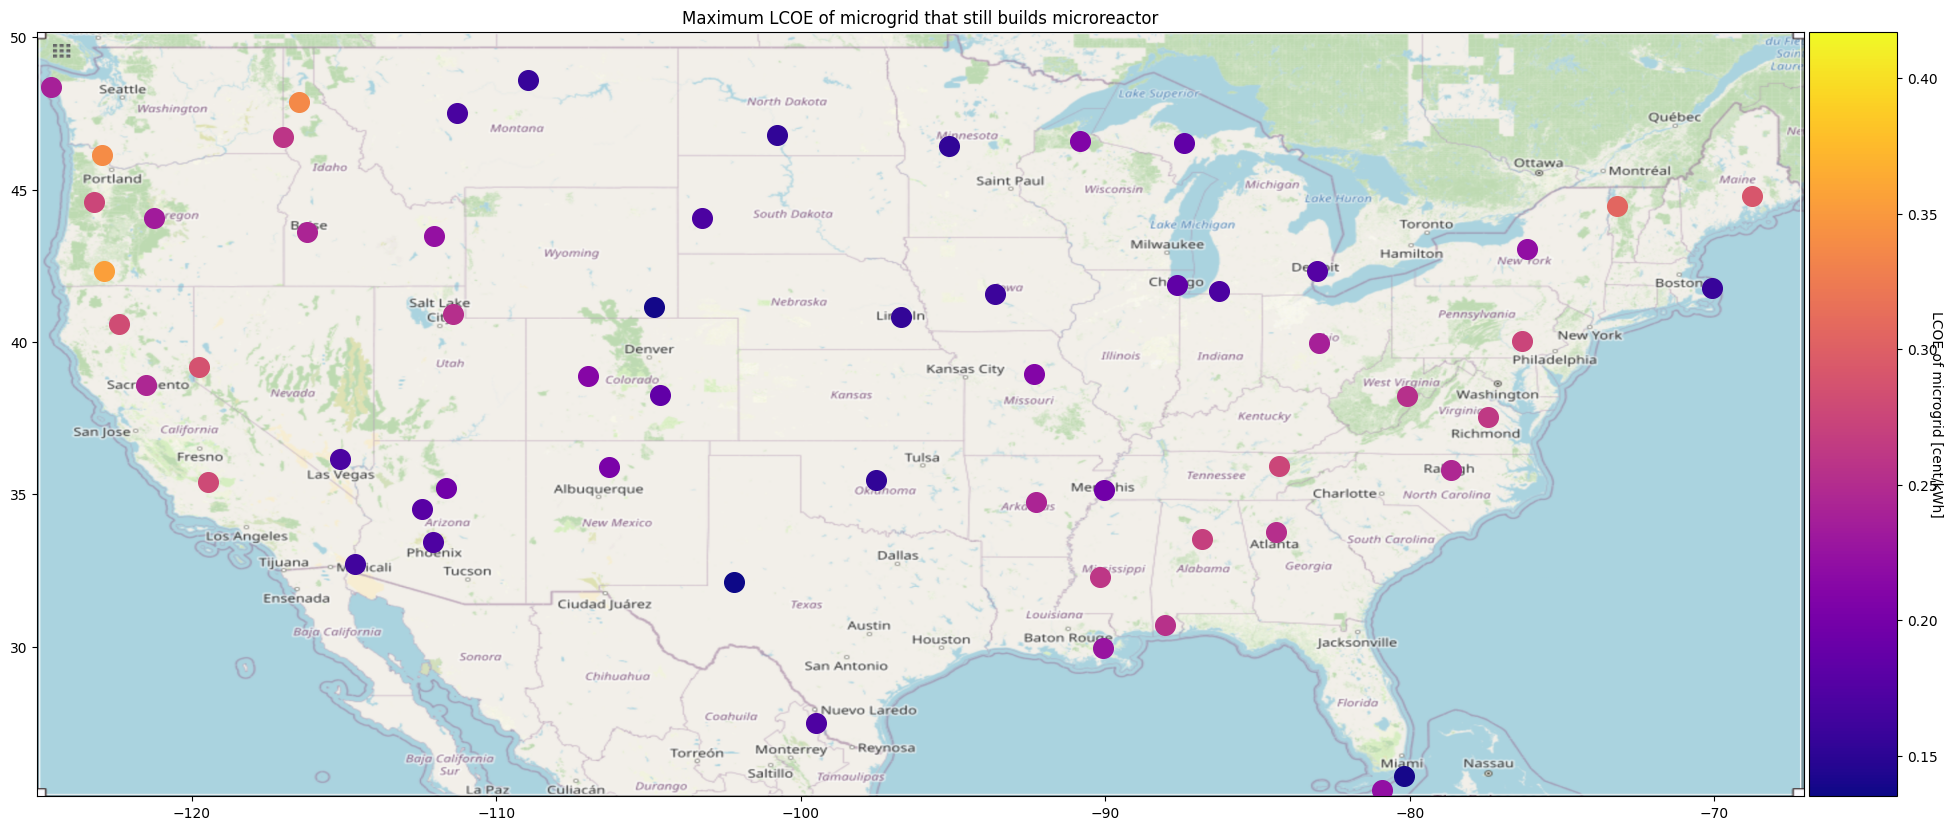

In [147]:
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
##### FIX MAP, MAYBE NEW ONE
# MOVE DATA OFF OF TEXT
# BIGGER BUTTON
# BETTER SCALE

## Fixing map to have kcc, LCOE data
# find city, max LCOE, OCC data point for microreactor
city_max_dict = {}
city_occ_dict = {}
for kcc in uRX_LCOE_dict_koppen:
    for city in uRX_LCOE_dict_koppen[kcc]:
        try:
            city_max_dict[city]=max(uRX_LCOE_dict_koppen[kcc][city])
        except: 
            pass
for kcc in uRX_cost_dict_koppen:
    for city in uRX_cost_dict_koppen[kcc]:
        try:
            city_occ_dict[city]=max(uRX_cost_dict_koppen[kcc][city])
        except: 
            pass
#print(city_max_dict)
#print(city_occ_dict)


BBox = ((-125.068,   -67.061,      
         25.083, 50.183))
ruh_m = plt.imread(os.getcwd() + '/usa_map.png')

for city in coords_df['Name/Nearby Landmark']:
    if city in city_max_dict.keys():
        pass #print(city)
min_LCOE = min(city_max_dict.values())
max_LCOE = max(city_max_dict.values())
print(min_LCOE,max_LCOE)

cmap = plt.cm.plasma
norm = mpl.colors.Normalize(vmin=min_LCOE,vmax=max_LCOE)
fig, ax = plt.subplots(figsize = (24,16))
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
#display(city_max_dict)
for i in range(len(coords_df['Neg. Longitude'])):
    #print(i)
    city = coords_df['Name/Nearby Landmark'][i]
    #print(city, 1000*round(city_max_dict[city],3), coords_df['Neg. Longitude'][i] , coords_df['Latitude (decimal degrees)'][i])
    ax.scatter(coords_df['Neg. Longitude'][i] , coords_df['Latitude (decimal degrees)'][i], zorder=1,  c = city_max_dict[city],cmap=cmap,norm =norm,  s=200)
    #ax.annotate( f"{city}" , (coords_df['Neg. Longitude'][i], coords_df['Latitude (decimal degrees)'][i]))


ax.set_title('Maximum LCOE of microgrid that still builds microreactor')
ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])
cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),cax=cax,orientation='vertical')
cbar.set_label('LCOE of microgrid [cent/kWh]', x=1, rotation=-90)

ax.imshow(ruh_m, zorder=0, extent = BBox, aspect= 'equal')
plt.savefig(image_dir + '/loc_var_all.png')

In [ ]:
m = len(Case2CFA)
fig = plt.figure(figsize=(24,12))
barWidth = 0.25
# Grabbing Generator Size Data
bars1 = Case2CFA["Architecture/GenLarge\n(kW)"]
#bars15 = Case25CFA["Architecture/GenLarge\n(kW)"]
bars2 = Case3CFA["Architecture/GenLarge\n(kW)"]
#bars25 = Case35CFA["Architecture/GenLarge\n(kW)"]
bars3 = Case4CFA["Architecture/GenLarge\n(kW)"]
#ranges
r1 = np.arange(m)
#r15 = [x+barWidth for x in r1]
r2 = [x+barWidth for x in r1]
#r25 = [x+barWidth for x in r2]
r3 = [x+barWidth for x in r2]

# Plotting
plt.bar(r1, bars1, width=barWidth, edgecolor='white', label='LowCostNuclear')
#plt.bar(r15, bars15, width=barWidth, edgecolor='white', label='LoMidCostNuclear')
plt.bar(r2, bars2, width=barWidth, edgecolor='white', label='MidCostNuclear')
#plt.bar(r25, bars25, width=barWidth, edgecolor='white', label='MidCostNuclear')
plt.bar(r3, bars3, width=barWidth, edgecolor='white', label='HighCostNuclear')
# Add xticks on the middle of the group bars
plt.ylabel('Installed Nuclear Capacity [MWe]',fontweight='bold')
plt.xlabel('[Cfa] Humid Subtropical Locations',fontweight='bold')
plt.title('Predicted Installed Nuclear Capacity for Modeled Cfa Locations',fontweight='bold')
plt.xticks([r + barWidth for r in range(m)], Case2CFA.index.values)
plt.xticks(rotation=90);
plt.grid(True)
 


In [ ]:
# Initial KCC Plots
with plt.rc_context():
    plt.rcParams['axes.prop_cycle'] = cycler(color=['black', 'red', 'orange', 'saddlebrown', 'gold','olivedrab','lawngreen',
                                                    'darkgreen','lime','lightseagreen','cyan','deepskyblue','blue',
                                                    'indigo', 'fuchsia','crimson'])
    fig = plt.figure()
    fig, ax=plt.subplots(figsize=(12,6))
    #ax.scatter( Case1CFA.index.array, Case1CFA['Architecture/GenLarge\n(kW)']*1000,marker='*',s=200)
    ax.bar( Case2CFA.index.array, Case2CFA['Architecture/GenLarge\n(kW)']/1000)
    ax.bar( Case3CFA.index.array, Case3CFA['Architecture/GenLarge\n(kW)']/1000)
    ax.bar( Case4CFA.index.array, Case4CFA['Architecture/GenLarge\n(kW)']/1000)
    ax.legend([ 'LowCostNuclear', 'MidCostNuclear', 'HighCostNuclear'], fontsize='large')
    plt.ylabel('Installed Nuclear Capacity [MWe]')
    plt.xlabel('[Cfa] Humid Subtropical Locations')
    plt.xticks(rotation=90);
    #plt.yticks([3,4,5])
    ax.grid(True)
    plt.savefig(image_dir + '/kcc_cfa_comp.svg')